In [1840]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as rnd
import random
import math
import copy
import seaborn as sns

### Parameters settings

In [1841]:
num_pop = 100
dimension = 10
size = 6 #x1 (0<=X<=1 by binary), #x2~x10 (-5<=X<=5 by binary)

crossover_prob = 0.9 # 0.7, 0.8, 0.9
mutation_prob = 0.05 # 0.01, 0.03, 0.05

function_selected = "ZDT4" #Sphere #Rastrigin 

### Generate a solution
해 생성 및 이진수를 십진수로 바꾸는 함수

In [1842]:
"""
Generate random solution
"""
def generate_random_solution(size,dimension):
    #> 한번에 만들기!
    solution = []      
    
    """
    해 생성
    """
    # x1: 무조건 plus
    chromosome = []
    current_size = 0
    while current_size < size:
        chromosome.append(random.randint(0,1))
        current_size = current_size + 1
    solution.append(chromosome)
    
    # x2~x10
    for d in range(1, dimension):
        # print(d)
        chromosome = []
        current_size = 0
        while current_size < size:
            chromosome.append(random.randint(0,1))
            current_size = current_size + 1
        solution.append(chromosome)
    
    return solution

"""
Chromosome genotype solution value function
"""

def chromosome_bin_to_decimal(chromosome): 
    
    decimal_chromosome = []
    for d in range(0,dimension):
        
        if d == 0:
            power = 0
            sum = 0
            for idx in range(0,len(chromosome[d])):
                sum = sum + (chromosome[d][idx]) * (2**power)
                power = power - 1
            decimal_chromosome.append(sum)
        else:
            power = 2
            sum = 0
            for idx in range(0,len(chromosome[d])-1):
                sum = sum + (chromosome[d][idx]) * (2**power)
                power = power - 1
            if chromosome[d][len(chromosome[d])-1] == 1:
                pass
            else:
                sum = -sum            
            
            decimal_chromosome.append(sum)
              
    return decimal_chromosome


In [1843]:
# chromosome = generate_random_solution(size,dimension)
# print(chromosome)

# decimal_chromosome = chromosome_bin_to_decimal(chromosome)
# print(decimal_chromosome)

### Function definition(ZDT4)
함수 정의 ZDT4

In [1844]:
"""
ZDT4
input: decimal
"""
def ZDT4(chromosome_dec):
    # 0~9
    
    #> f1(x) = x1
    f1 = chromosome_dec[0]
    
    #> f2(x) = ~, g(x)
    sum_term = 0
    for i in range(1, dimension):
        x = chromosome_dec[i]
        
        sum_term = sum_term + (x**2 - 10 * math.cos(4 * math.pi * (x)))
    
    gx = 1 + 10*(dimension-1) + sum_term
    
    f2 = gx * (1 - (chromosome_dec[0]/gx)**(1/2))    
    
    return [f1, f2]

### Gen Initial solutions
랜덤 해 생성 돌려서 초기해 생성하기(warm condition)

In [1845]:
"""
Generate initial solution
"""

def generate_initial_solution():
    #
    solution_set = []
    successful_pop = 1
    while successful_pop <= num_pop:
        
        # Generate        
        temp_chromosome = generate_random_solution(size, dimension)
        temp_chromosome_dec = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution:  0~1, -5~+5
        TorF_list = []
        for idx in range(0, len(temp_chromosome_dec)):
            if idx == 0:
                element = (0 <= temp_chromosome_dec[idx]) & (temp_chromosome_dec[idx] <= 1)
                TorF_list.append(element)
            else:
                element = (-5 <= temp_chromosome_dec[idx]) & (temp_chromosome_dec[idx] <= 5)
                TorF_list.append(element)
                
        if all(TorF_list):
            solution_set.append(temp_chromosome)
            successful_pop = successful_pop + 1
            # print(f'successful_pop: {successful_pop}')
        else:
            # print("infeasible")
            pass
        
        
    return solution_set

### Operator: rank
rank를 부여하는 함수

In [1846]:
"""
Rank를 부여하는 함수
# input: solution
# output: rank list
"""
def rank_operator_old(solution):

    #> 1. solution 받아와서 십진수로 바꾸고 multi obj 꼴로 담기 =====================
    multiobjective_list = []
    for idx in range(0,len(solution)):
        onething = solution[idx]
        # print(ZDT4(chromosome_bin_to_decimal(onething)))
        multiobjective_list.append(ZDT4(chromosome_bin_to_decimal(onething)))
        
    #> 2. 자기자신 포함, 본인이 dominate하는 원소 개수 ==========================================
    dom_num_list = []
    for idx in range(0,len(multiobjective_list)):
        #> 기준이 되는 base
        # print(idx)
        base_list = multiobjective_list[idx]
        
        #> 대상이 되는 explore
        count = 0
        for idx_exp in range(0,len(multiobjective_list)):
            exp_list = multiobjective_list[idx_exp]
            
            #> 비교
            if (base_list[0] <= exp_list[0]) & (base_list[1] <= exp_list[1]):
                count = count + 1
        
        dom_num_list.append(count)  

    # print(f'dom_num_list: {dom_num_list}')

    #> 3. unique sort해서 순서대로 세워서 점수 list 생성 ==========================================
    rank_list = np.unique(dom_num_list).tolist()
    rank_list.sort(reverse=True)
    # print(f'rank_list: {rank_list}')

    dom_rank_list = []
    for idx in range(0, len(dom_num_list)):
        dom_rank_list.append(rank_list.index(dom_num_list[idx])+1)
    # print(f'dom_rank_list: {dom_rank_list}')

    return dom_rank_list

In [1847]:
def rank_operator(solution):

    #> 1. solution 받아와서 십진수로 바꾸고 multi obj 꼴로 담기 =====================
    multiobjective_list = []
    for idx in range(0,len(solution)):
        onething = solution[idx]
        # print(ZDT4(chromosome_bin_to_decimal(onething)))
        multiobjective_list.append(ZDT4(chromosome_bin_to_decimal(onething)))
    # print(f'multiobjective_list: {multiobjective_list}')

    #> 2. f1: 0~자기자신 & f2: 0~자기자신인 원소 개수가 0이면 non-dominated
    rank_point_list = [0 for i in range(0, len(multiobjective_list))]
    # print(f'rank_point_list: {rank_point_list}')
    copy_multiobj_list = copy.deepcopy(multiobjective_list)

    #> 3. 반복문 Rank 점점 올려가면서 count == 0이면 rank 주고 없애기
    exp_list = list(range(0, len(multiobjective_list)))
    rank_point = 1
    while len(exp_list) != 0:
        # print(f'rank_point: {rank_point} ::::::::::::')
        will_be_deleted_list = []
        #> 3.1. 조건을 만족하면 rank point 부여
        for idx in exp_list:
            temp_point = copy_multiobj_list[idx]
            # print(temp_point)
            
            f1_point = temp_point[0]
            f2_point = temp_point[1]
            
            # 0~f1 & 0~f2 탐색
            count = 0
            for idx_exp in exp_list:
                if ((0<copy_multiobj_list[idx_exp][0]) & (copy_multiobj_list[idx_exp][0]<f1_point)) & ((0<copy_multiobj_list[idx_exp][1]) & (copy_multiobj_list[idx_exp][1]<f2_point)):
                        count = count+1
            # print(f'count: {count}')
            if count == 0:
                rank_point_list[idx] = rank_point_list[idx] + rank_point
                will_be_deleted_list.append(idx)
                
        # #> 3.2. 0받은 index는 다음 탐색 범위에서 제거
        for delete_idx in will_be_deleted_list:
            exp_list.pop(exp_list.index(delete_idx))
            
        rank_point = rank_point + 1
        # print(f'rank_point_list: {rank_point_list}')
        
    return rank_point_list


### Crossver and Mutation

In [1848]:
def execute_crossover_standard(solution_1, solution_2):
    # 완료
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)

    dim = 0
    while dim < dimension:
        if random.random() <= 1.0:
            current_sol1 = solution_1_tmp[dim]
            current_sol2 = solution_2_tmp[dim]
            
            new_sol1 = copy.deepcopy(current_sol1)
            new_sol2 = copy.deepcopy(current_sol2)
                    
            point_loc = random.randint(1,(len(current_sol1)-1))
            # print(point_loc)
            
            for loc_idx in range(0, point_loc):
                new_sol1[loc_idx] = current_sol2[loc_idx]
                new_sol2[loc_idx] = current_sol1[loc_idx]
            
            solution_1_tmp[dim] = new_sol1
            solution_2_tmp[dim] = new_sol2
            
        dim = dim + 1

    return solution_1_tmp, solution_2_tmp

def execute_mutation_standard(new_solution_1, new_solution_2):
    
    dim = 0
    while dim < dimension:
        remember_signal = -99
        # Select
        if random.random() <= 0.5:
            mutation_target_chromosome = copy.deepcopy(new_solution_1)
            remember_signal = 1
        else:
            mutation_target_chromosome = copy.deepcopy(new_solution_2)
            remember_signal = 2
        
    # print("!: ",remember_signal)

    # Choose the location randomly along all dimension 
    # dim = 0
    # while dim < dimension:
        temp_chromosome = mutation_target_chromosome[dim]
        # print(temp_chromosome)
        
        point_loc = random.randint(0,(len(temp_chromosome)-1))
        # print(point_loc)
        # print(f'{point_loc}: {temp_chromosome[point_loc]}')
        
        if temp_chromosome[point_loc] == 0:
            temp_chromosome[point_loc] = 1
        else:
            temp_chromosome[point_loc] = 0
            
        # print(temp_chromosome)
        # print("\n")
        dim = dim + 1

    if remember_signal == 1:
        new_solution_1 = copy.deepcopy(mutation_target_chromosome)
    elif remember_signal == 2:
        new_solution_2 = copy.deepcopy(mutation_target_chromosome)
    else:
        print("error")
        
    return new_solution_1, new_solution_2


### Offsprings roulette-wheel selection
Rank의 역수 기반 룰렛휠 selection

In [1849]:
def select_based_on_rank(solution):

    #> rank 매기기; index 1~100
    rank_solution = rank_operator(solution)
    # print(rank_solution)

    #> 선택확률 prob_list_select 만들기
    prob_list_select = []
    denomi = 0
    for i in rank_solution:
        denomi = denomi + (1/i) 

    for i in rank_solution:
        prob_list_select.append((1/i)/denomi)

    #> 생성한 선택확률을 기반으로 0~99 중 2개 선택하기
    # num_list = list(range(0,num_pop))
    num_list = list(range(0, len(solution)))

    # num_pop/2 만큼 반복해서 100개짜리 offsprings solution 만들기
    off_solution = []
    while len(off_solution) < num_pop:

        selected_pop = np.random.choice(num_list, 2, p=prob_list_select, replace=False)
        selected_pop = selected_pop.tolist()


        solution_1 = solution[selected_pop[0]]
        solution_2 = solution[selected_pop[1]]

        # =======================================================================================

        #> CROSSOVER
        if random.random() <= crossover_prob:
            new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
            
        else:
            new_solution_1 = copy.deepcopy(solution_1)
            new_solution_2 = copy.deepcopy(solution_2)

        #> MUTATION
        if random.random() <= mutation_prob:
            new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
            
        else:
            new_solution_1 = copy.deepcopy(new_solution_1)
            new_solution_2 = copy.deepcopy(new_solution_2)

        #> Append new solutions
        off_solution.append(new_solution_1)
        off_solution.append(new_solution_2)
        
    return off_solution

### Calculate crowding distance

In [1850]:
# np.random.choice(range(0,2), 2, replace=False).tolist()

In [1851]:
def calculate_crowding_dist(solution_dist):


    for i in range(0,len(solution_dist)):
        # print(solution_dist[i])
        pass
        
    multiobjective_list = []
    for idx in range(0,len(solution_dist)):
        onething = solution_dist[idx]
        # print(ZDT4(chromosome_bin_to_decimal(onething)))
        multiobjective_list.append(ZDT4(chromosome_bin_to_decimal(onething)))
    # print(f'multiobjective_list: len={len(multiobjective_list)}\n{multiobjective_list}')

    #> list to dict
    # dict_list = dict(zip(range(len(multiobjective_list)),multiobjective_list))
    # print(f'dict_list: {dict_list}')
    # print(list(dict_list.keys())[0])
    # print('\n')

    if len(multiobjective_list) == 1:
        return_solution = copy.deepcopy(solution_dist)
        return_distance = []
        return_distance.append(float('inf'))
        
    elif len(multiobjective_list) == 2:
        ran_num_list = np.random.choice(range(0,2), 2, replace=False).tolist()
        
        return_solution = []
        return_solution.append(solution_dist[ran_num_list[0]])
        return_solution.append(solution_dist[ran_num_list[1]])
        
        return_distance = []
        return_distance.append(float('inf'))    
            
    elif len(multiobjective_list) > 2:
        ########## 3개 이상인 경우 ###
        #> f1 ==================================================================
        # print("::: f1 :::")
        ##> 순서 정렬(f1에 대해서; key=lambda x:x[0])
        obj_list = copy.deepcopy(multiobjective_list)
        obj_list.sort(key=lambda x:x[0])
        # print(obj_list)

        ##> unique 뽑기
        single_pop1 = []
        for idx in range(0,len(obj_list)):
            single_pop1.append(obj_list[idx][0])
        single_pop1 = np.unique(single_pop1).tolist()
        # print(f'single_pop:{single_pop1}')

        ##> crowding dist by single_pop
        dist_list_f1 = []
        fmax = single_pop1[-1]
        fmin = single_pop1[0]


        dist_list_f1.append(float('inf'))
        for idx in range(1, (len(single_pop1)-1)):
            dist_list_f1.append( (single_pop1[idx+1]-single_pop1[idx-1])/(fmax-fmin))
        dist_list_f1.append(float('inf'))
        # print(f'dist_list_f1: {dist_list_f1}') 


        ##> f2 ==================================================================
        # print("::: f2 :::")
        ##> 순서 정렬(f1에 대해서; key=lambda x:x[0])
        obj_list = copy.deepcopy(multiobjective_list)
        obj_list.sort(key=lambda x:x[1])
        # print(obj_list)

        ##> unique 뽑기
        single_pop2 = []
        for idx in range(0,len(obj_list)):
            single_pop2.append(obj_list[idx][1])
        single_pop2 = np.unique(single_pop2).tolist()
        # print(f'single_pop:{single_pop2}')

        ##> crowding dist by single_pop
        dist_list_f2 = []
        fmax = single_pop2[-1]
        fmin = single_pop2[0]


        dist_list_f2.append(float('inf'))
        for idx in range(1, (len(single_pop2)-1)):
            dist_list_f2.append( (single_pop2[idx+1]-single_pop2[idx-1])/(fmax-fmin))
        dist_list_f2.append(float('inf'))
        # print(f'dist_list_f1: {dist_list_f2}\n') 


        ##> 점수 합산 ===========================================================
        crowding_dist_list = [0 for i in range(0,len(multiobjective_list))]
        # print(f'crowding_dist_list: {crowding_dist_list}')
        for idx in range(0,len(multiobjective_list)):
            target = multiobjective_list[idx]

            #! f1
            index_f1 = single_pop1.index(target[0])
            crowding_dist_list[idx] = crowding_dist_list[idx] + dist_list_f1[index_f1]

            #! f2
            index_f2 = single_pop2.index(target[1])
            crowding_dist_list[idx] = crowding_dist_list[idx] + dist_list_f2[index_f2]
            
        # print(f'crowding_dist_list: {crowding_dist_list}')


        order_for_return = sorted(range(len(crowding_dist_list)), key=lambda k: crowding_dist_list[k], reverse=True)
        # print(f'order_for_return: {order_for_return}\n')

        return_solution = []
        return_distance = []
        for idx in order_for_return:
            return_solution.append(solution_dist[idx])
            return_distance.append(crowding_dist_list[idx])

        # print(f'return_distance: {return_distance}')
        
    else:
        print('error! code 101')


    return return_solution, return_distance


### Model 1
rank 부여해서 먼저 담고 tie 생길 때 crowding distance로 가려내기

In [1852]:
def model1_op_old(solution):
    
    rank_sol = rank_operator(solution)

    # print(f'rank_sol: {rank_sol}')
    # print(len(rank_sol))

    rank_sol_arrange = copy.deepcopy(rank_sol)

    rank_sol_arrange = np.unique(rank_sol_arrange).tolist()
    rank_sol_arrange.sort(reverse=False)

    # print(f'rank_sol_arrange: {rank_sol_arrange}')
    #> 1. index로 찾아내고 num_pop이 살짝 넘치게 담아놓기 =======================================
    ##> ex. rank 61인 index 찾아서 해당하는 solution 담기
    return_solution = []
    index_list = []
    rank_list = []
    for rank in rank_sol_arrange:
        # print(f'rank: {rank}')
        
        # 해당하면 하나씩 넣기
        index_tmp_list = []
        for idx, sol_num in enumerate(rank_sol):
            if sol_num == rank:
                index_tmp_list.append(idx)
                # print(index_tmp_list)
        # 완료된 index_tmp_list 넣기
        for idx in index_tmp_list:
            index_list.append(idx)
            
        rank_list.append(rank)
        if len(index_list) >= num_pop:
            break

    for idx in index_list:
        return_solution.append(solution[idx])

    # print(f'return_solution: {len(return_solution)}')

    # print(f'used rank_list: {rank_list}')

    #> 2. 100여개 중에서 crowding distance로 가려내기 =======================================
    ##> ex. 마지막 파트 num_pop 넘는 분량 만큼 crowding dist

    #> 2.1. 마지막 파트 골라내기
    if len(return_solution) == num_pop:
        # print(f'{len(return_solution)}== 100 ......!')
        final_solution_list = copy.deepcopy(return_solution)
        pass
    else:
        deleted_candiate_list = []
        index_tmp_list = []
        for idx, sol_num in enumerate(rank_sol):
            if sol_num == rank_sol_arrange[-1]:
                index_tmp_list.append(idx)
                # print(index_tmp_list)
        for idx in index_tmp_list:
            deleted_candiate_list.append(idx)
            
        # print(deleted_candiate_list)

        #> 2.2. 해당 solution들 crowding distance 계산하기
        solution_input = []
        for idx in deleted_candiate_list:
            solution_input.append(solution[idx])
            # print(f'solution[{idx}]: {solution[idx]}')
        # print(f'solution_input:\n{solution_input}')


        solution_new, solution_dist = calculate_crowding_dist(solution_input)
        
        final_solution_list = []
        #> deleted_candiate_list만큼 지우고 solution 형태로 solution_new붙이고 return
        ##> (1) pop 
        for d in deleted_candiate_list:
            index_list.pop(-1)
        for idx in index_list:
            final_solution_list.append(solution[idx])    
        # print(f'index_list: {index_list}')
        
        ##> (2) solution_new
        num_return = num_pop - len(final_solution_list)
        # print(f'num_return: {num_return}')
        for num in range(0,num_return):
            final_solution_list.append(solution_new[num])
            
        # print(len(final_solution_list))

    return final_solution_list

In [1853]:
def model1_op(solution):
    
    rank_sol = rank_operator(solution)
    # for i in range(0, len(rank_sol)):
    #     print(ZDT4(chromosome_bin_to_decimal(solution[i])))
    # print(f'rank_sol: {rank_sol}')

    rank_sol_arrange = copy.deepcopy(rank_sol)

    rank_sol_arrange = np.unique(rank_sol_arrange).tolist()
    rank_sol_arrange.sort(reverse=False)

    # print(f'\nrank_sol_arrange: {rank_sol_arrange}')

    #> 1. index로 찾아내고 num_pop이 살짝 넘치게 담아놓기 =======================================
    ##> ex. rank 61인 index 찾아서 해당하는 solution 담기
    return_solution = []
    index_list = []
    rank_list = []
    # last_rank_list = []
    for rank in rank_sol_arrange:
        # print(f'rank: {rank}')
        
        # 해당하면 하나씩 넣기
        index_tmp_list = []
        for idx, sol_num in enumerate(rank_sol):
            if sol_num == rank:
                index_tmp_list.append(idx)
                # print(index_tmp_list)
        # 완료된 index_tmp_list 넣기
        for idx in index_tmp_list:
            index_list.append(idx)
            
        rank_list.append(rank)
        if len(index_list) >= num_pop:
            # print('break!\n')
            break

    for idx in index_list:
        return_solution.append(solution[idx])
        
    # print(f'return_solution: {len(return_solution)}')
    # print(f'index_list: {index_list}')
    # print(f'rank_list: {rank_list}')
    #
    # for i in index_list:
    #     print(ZDT4(chromosome_bin_to_decimal(solution[i])))
    #> 2. 100여개 중에서 crowding distance로 가려내기 =======================================
    ##> ex. 마지막 파트 num_pop 넘는 분량 만큼 crowding dist

    #> 2.1. 마지막 파트 골라내기
    if len(return_solution) == num_pop:
        # print(f'{len(return_solution)}== 100 ......!')
        final_solution_list = copy.deepcopy(return_solution)
        pass
    else:
        deleted_candiate_list = []
        index_tmp_list = []
        
        for idx, sol_num in enumerate(rank_sol):
            if sol_num == rank_list[-1]:
                index_tmp_list.append(idx)
                # print(index_tmp_list)
        for idx in index_tmp_list:
            deleted_candiate_list.append(idx)
        # print(f'deleted_candiate_list: {deleted_candiate_list}')
        
        #> 2.2. 해당 solution들 crowding distance 계산하기
        solution_input = []
        for idx in deleted_candiate_list:
            solution_input.append(solution[idx])
        
        solution_new, solution_dist = calculate_crowding_dist(solution_input)
        
        # print('\n')
        # for i in range(0, len(solution_new)):
        #     print(ZDT4(chromosome_bin_to_decimal(solution_new[i])))
        # print(f'solution_dist: {solution_dist}')
        
        final_solution_list = []
        #> deleted_candiate_list만큼 지우고 solution 형태로 solution_new붙이고 return
        ##> (1) pop 
        for d in deleted_candiate_list:
            index_list.pop(-1)
        for idx in index_list:
            final_solution_list.append(solution[idx])    
        # print(f'index_list: {index_list}')
        
        ##> (2) solution_new
        num_return = num_pop - len(final_solution_list)
        # print(f'num_return: {num_return}')
        for num in range(0,num_return):
            final_solution_list.append(solution_new[num])
                
            # print(len(final_solution_list))

    return final_solution_list

### Model 2
dist * 1000/rank로 100개 추출하기

In [1854]:
solution = generate_initial_solution()
off_solution = select_based_on_rank(solution)
print(len(solution))
print(len(off_solution))
mixed_solution = copy.deepcopy(solution)
for idx in range(0,len(off_solution)):
    mixed_solution.append(off_solution[idx])
solution = copy.deepcopy(mixed_solution)

100
100


In [1855]:
# def model2_op(solution):
rank_sol = rank_operator(solution)
print(f'rank_sol: {rank_sol}')

rank_sol_arrange = copy.deepcopy(rank_sol)
rank_sol_arrange = np.unique(rank_sol_arrange).tolist()
rank_sol_arrange.sort(reverse=False)
print(f'rank_sol_arrange: {rank_sol_arrange}')

dist_list_each_rank = [0 for i in range(len(rank_sol))]

#> crowding dist 계산 보낼 index찾기 in rank_sol

for rank in rank_sol_arrange:
    input_rank_list = []
    for idx, rank_in in enumerate(rank_sol):
        if rank_in == rank:
            input_rank_list.append(idx)
    print(f'input_rank_list: {input_rank_list}')
    
    # solution input 만들기
    solution_input = []
    for idx in input_rank_list:
        solution_input.append(solution[idx])
    
    
    solution_new, solution_dist = calculate_crowding_dist(solution_input)


rank_sol: [12, 8, 2, 18, 3, 3, 11, 2, 4, 11, 4, 6, 5, 5, 3, 8, 6, 11, 1, 5, 14, 16, 6, 6, 6, 5, 7, 7, 4, 18, 7, 8, 11, 12, 1, 11, 1, 19, 9, 9, 17, 8, 9, 10, 19, 18, 15, 17, 6, 11, 10, 1, 1, 3, 14, 12, 6, 2, 19, 2, 2, 2, 9, 17, 5, 7, 7, 13, 10, 11, 6, 15, 6, 14, 3, 11, 13, 5, 9, 8, 7, 7, 2, 4, 15, 5, 8, 4, 16, 3, 10, 10, 7, 9, 9, 12, 18, 1, 7, 16, 10, 3, 1, 6, 2, 1, 1, 2, 5, 1, 2, 5, 2, 3, 7, 17, 4, 3, 10, 6, 1, 13, 6, 8, 2, 6, 2, 8, 1, 2, 4, 7, 14, 3, 4, 6, 4, 3, 7, 6, 4, 7, 1, 1, 1, 16, 1, 1, 6, 2, 13, 5, 6, 7, 12, 1, 14, 10, 8, 1, 2, 3, 3, 1, 4, 15, 10, 16, 12, 11, 2, 2, 9, 2, 6, 15, 4, 3, 8, 6, 4, 2, 1, 20, 5, 8, 5, 2, 9, 2, 1, 2, 9, 3, 2, 8, 4, 4, 12, 9]
rank_sol_arrange: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
input_rank_list: [18, 34, 36, 51, 52, 97, 102, 105, 106, 109, 120, 128, 142, 143, 144, 146, 147, 155, 159, 163, 182, 190]
input_rank_list: [2, 7, 57, 59, 60, 61, 82, 104, 107, 110, 112, 124, 126, 129, 149, 160, 170, 171, 173, 181, 187, 189, 19

### Plot
그림그리기

In [1856]:

def plot_for_solution(solution,iteration):
    multiobjective_list = []
    for idx in range(0,len(solution)):
        onething = solution[idx]
        # print(ZDT4(chromosome_bin_to_decimal(onething)))
        multiobjective_list.append(ZDT4(chromosome_bin_to_decimal(onething)))

    # print(multiobjective_list)
    plot_x_list = []
    plot_y_list = []
    for idx in range(0, len(multiobjective_list)):
        plot_x_list.append(multiobjective_list[idx][0])
        plot_y_list.append(multiobjective_list[idx][1])
        
    plt.scatter(plot_x_list,plot_y_list, s=10, color='black')
    plt.xlabel('f1')
    plt.ylabel('f2')
    # plt.xlim([0,1])      # X축의 범위: [xmin, xmax]
    # plt.ylim([0,1000])
    plt.title(f':::ZDT4  iteration: {iteration}:::')
    plt.show()

### Iteration (model1 vs model2)
- 시드 고정해서 model1과 model2의 성능 비교

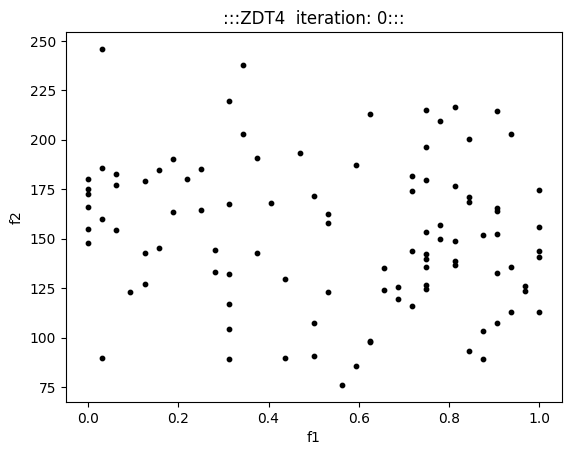

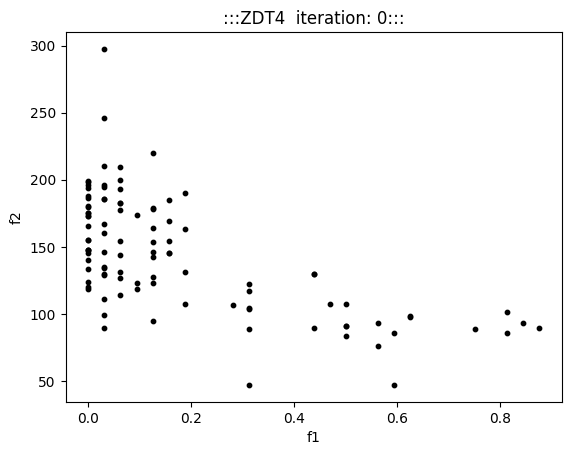

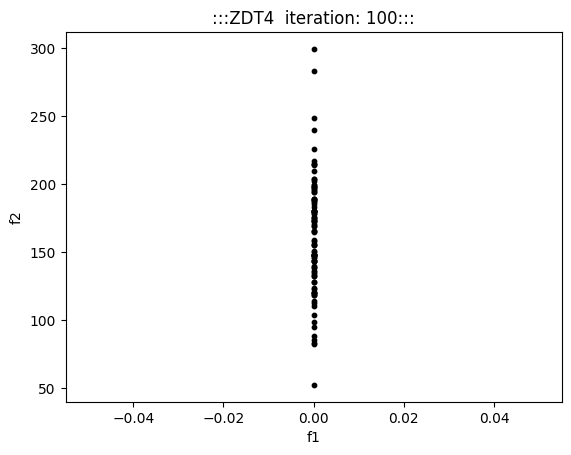

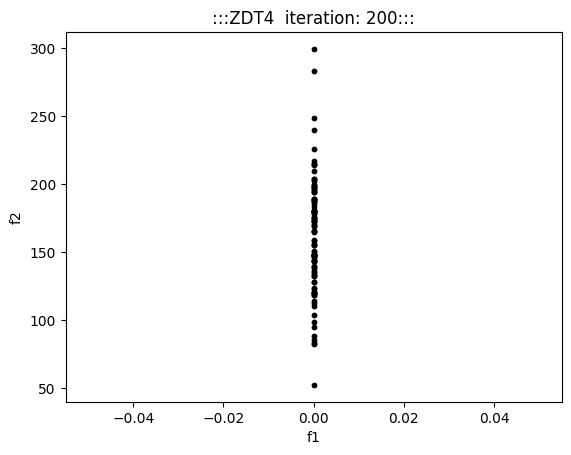

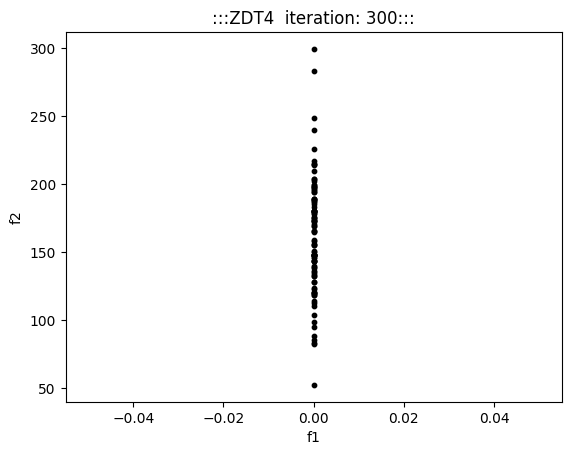

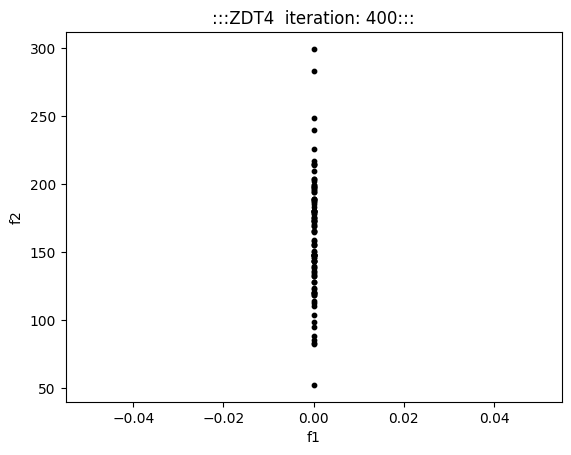

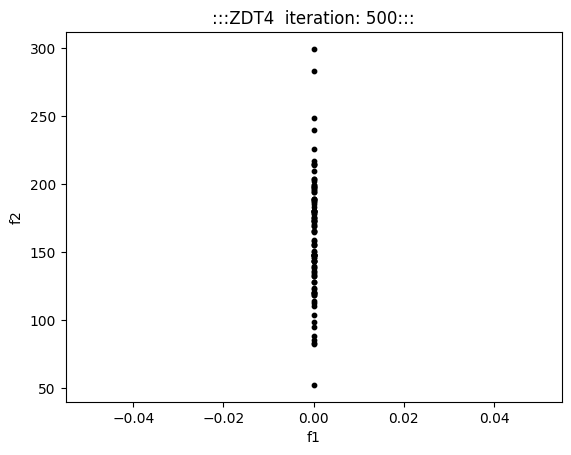

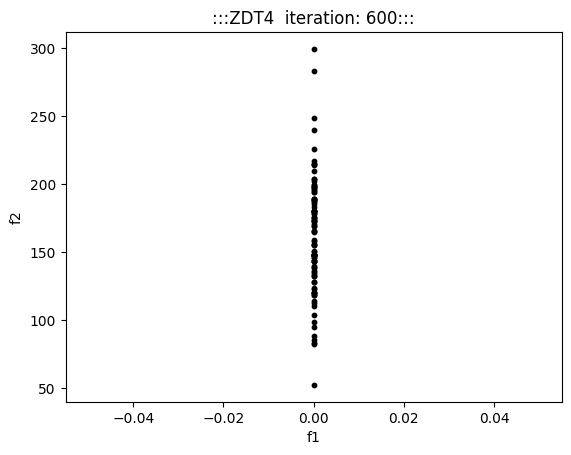

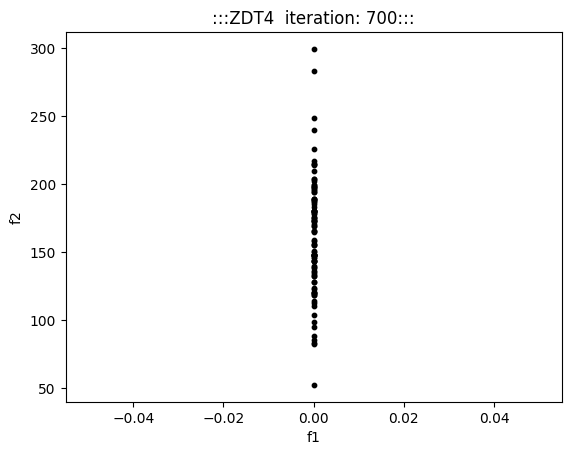

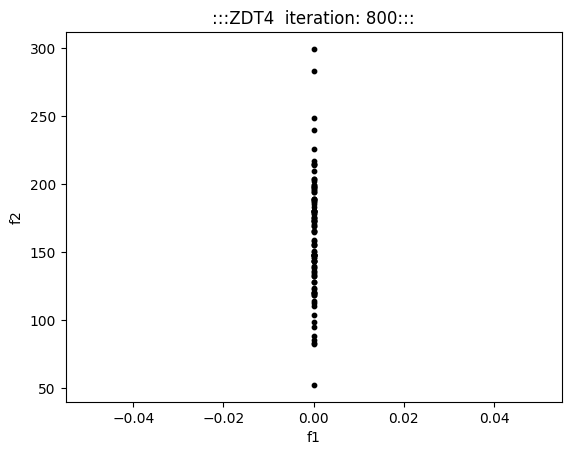

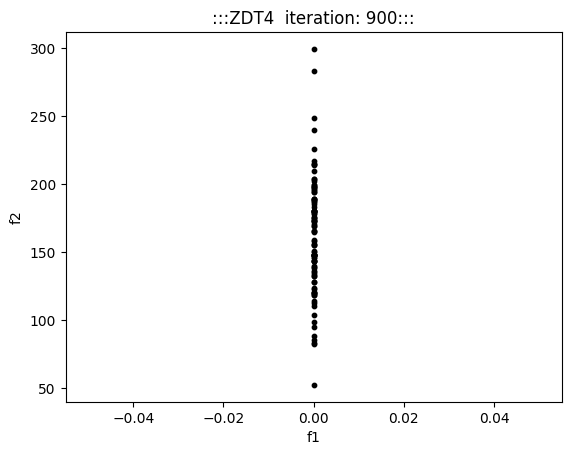

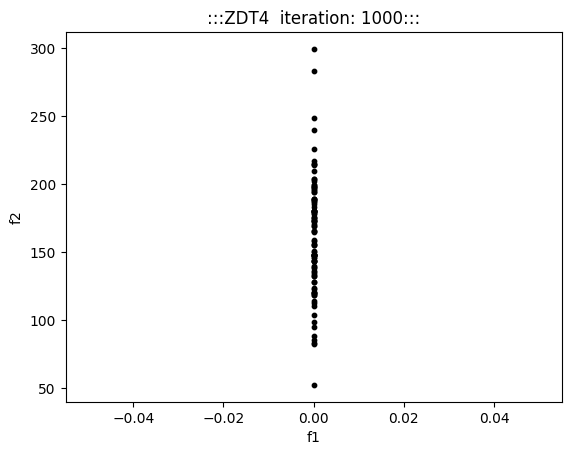

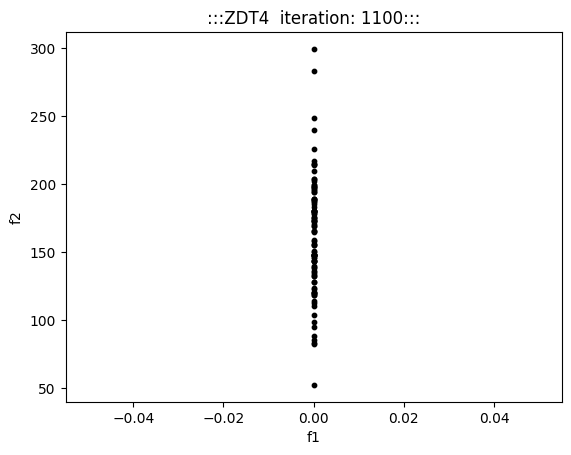

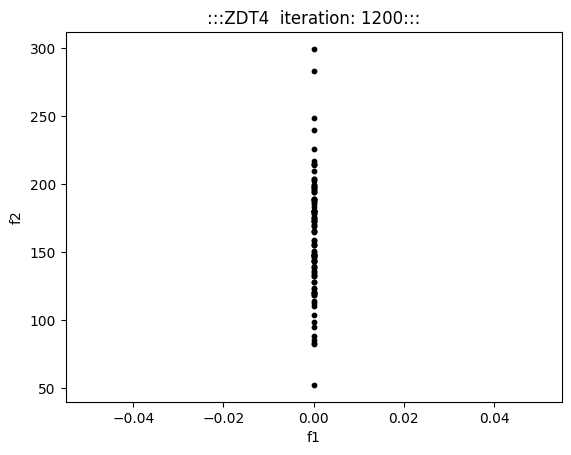

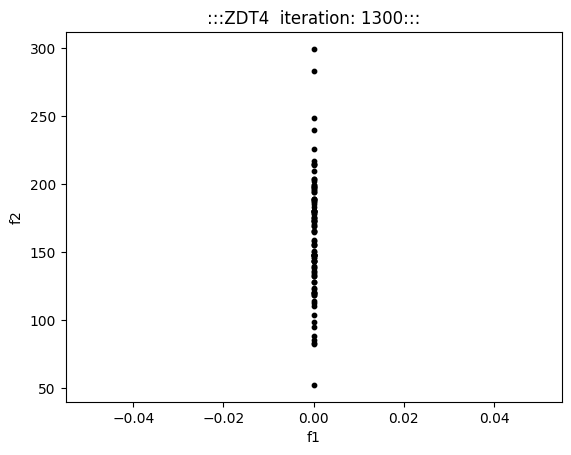

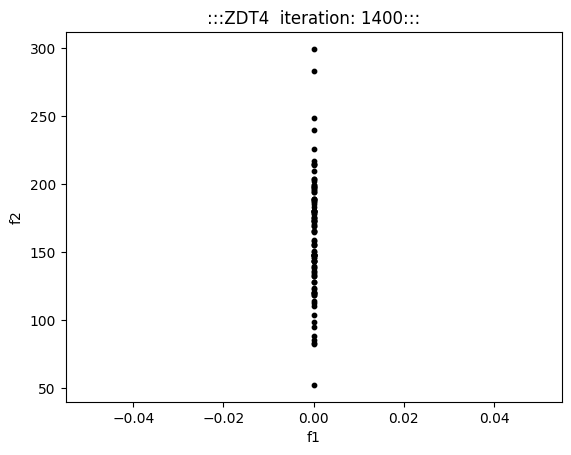

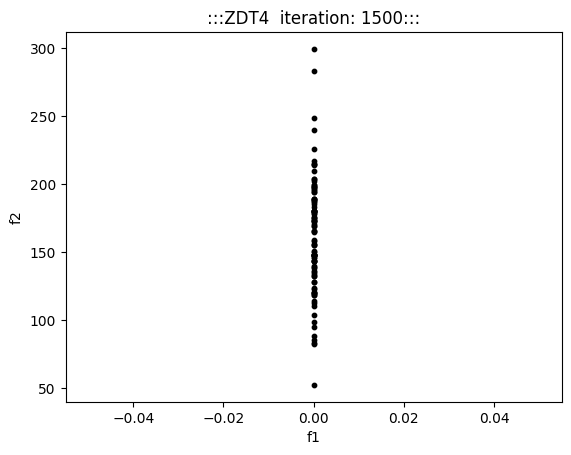

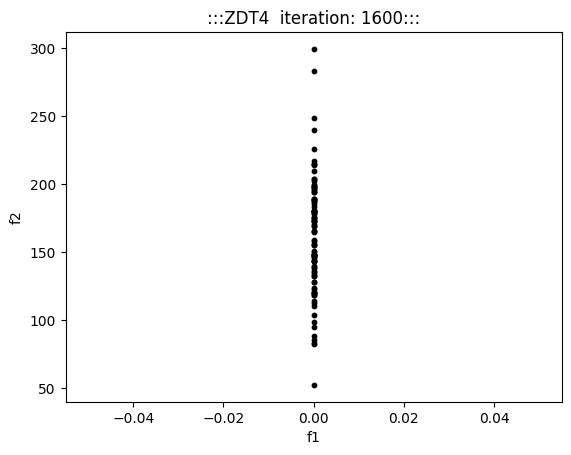

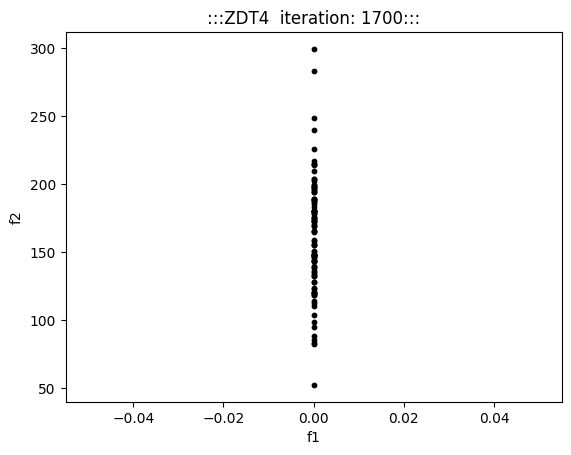

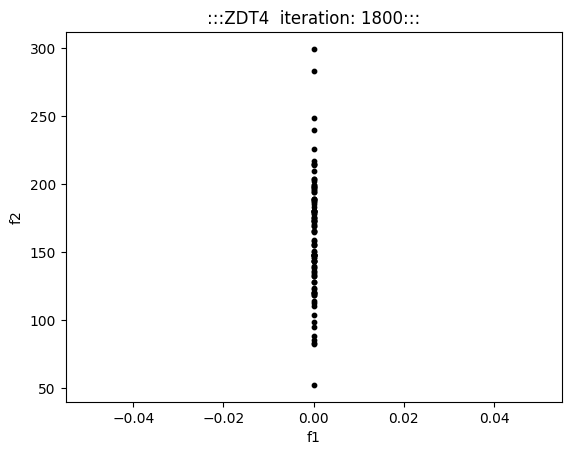

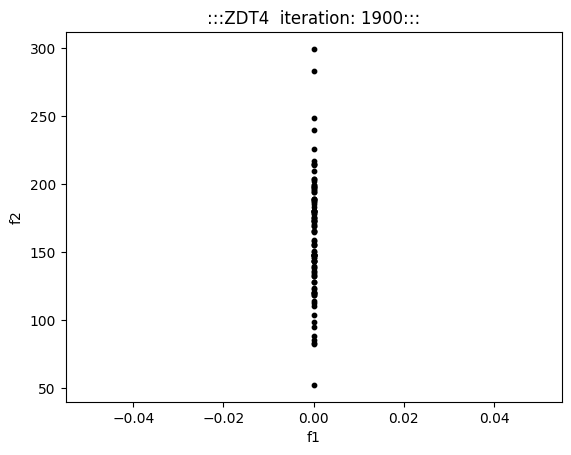

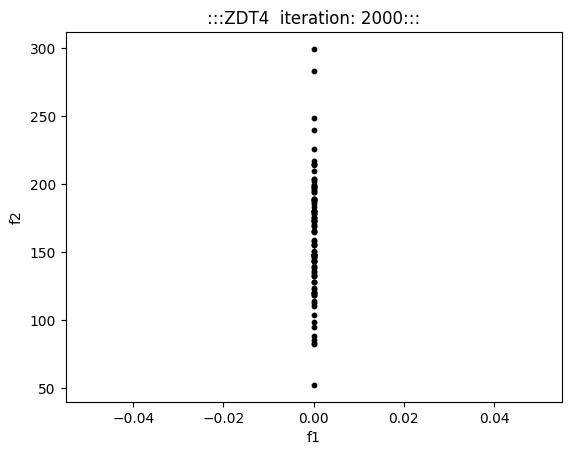

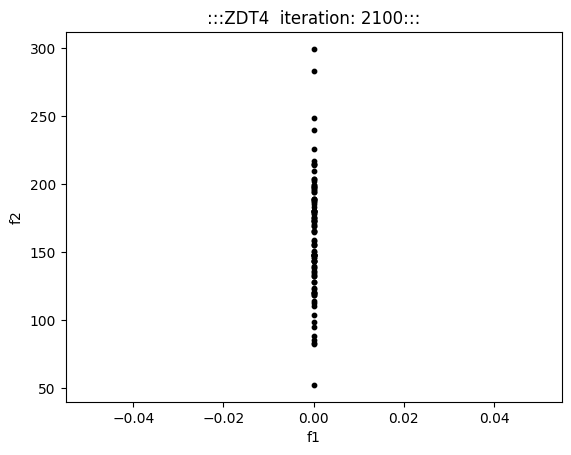

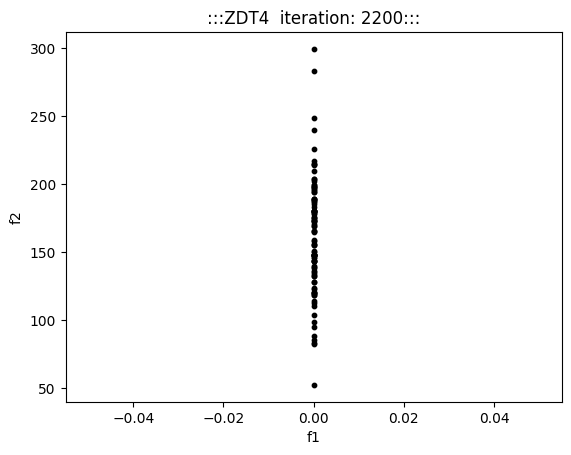

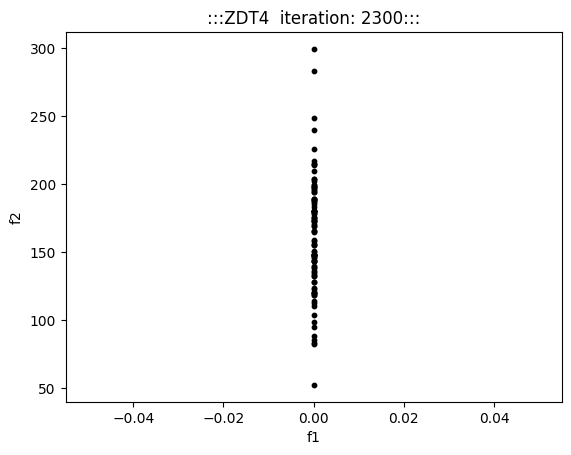

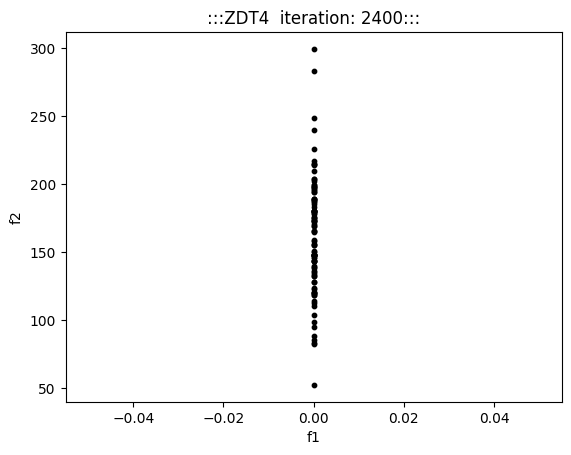

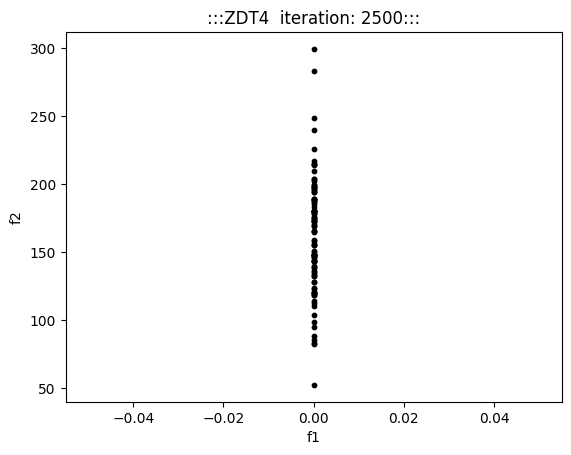

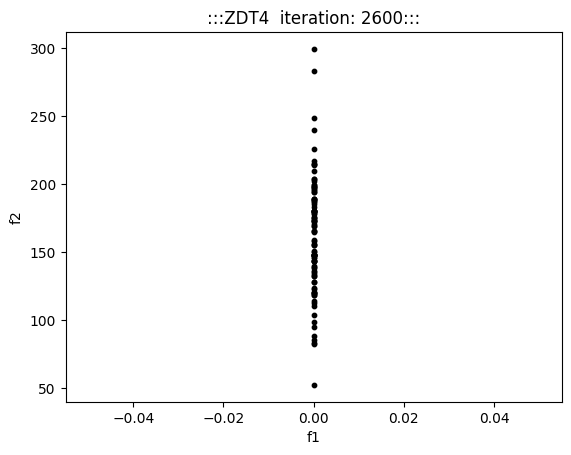

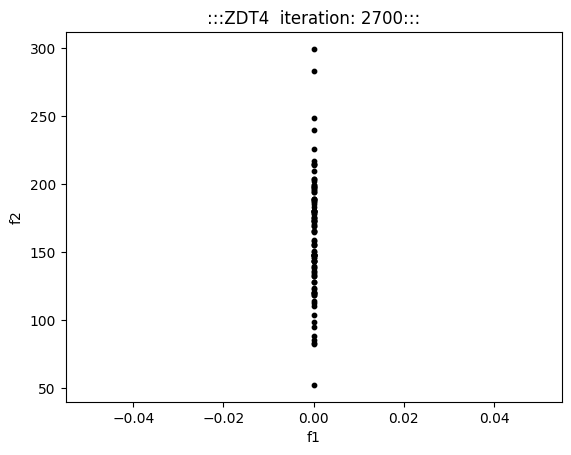

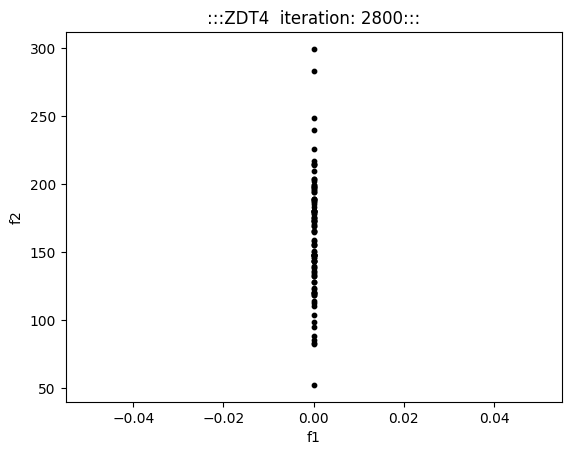

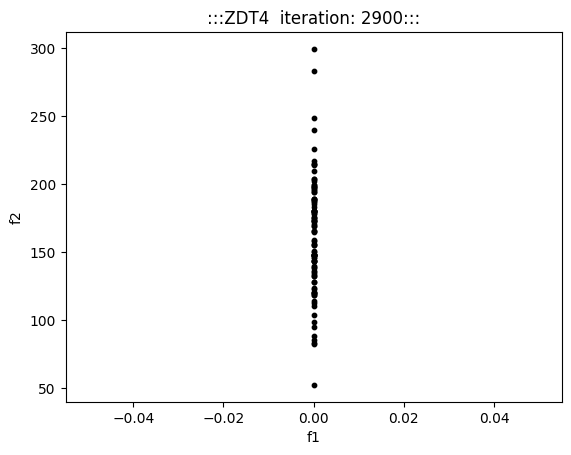

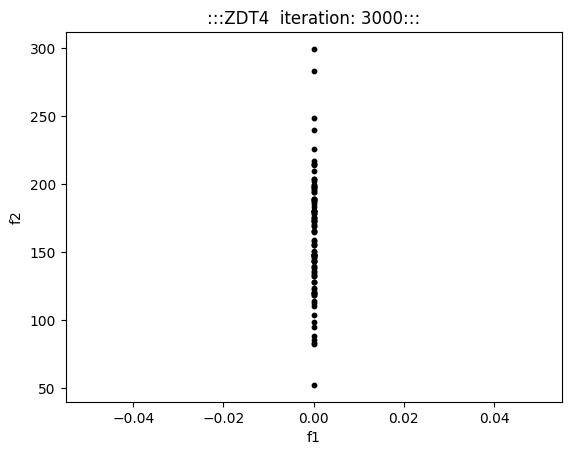

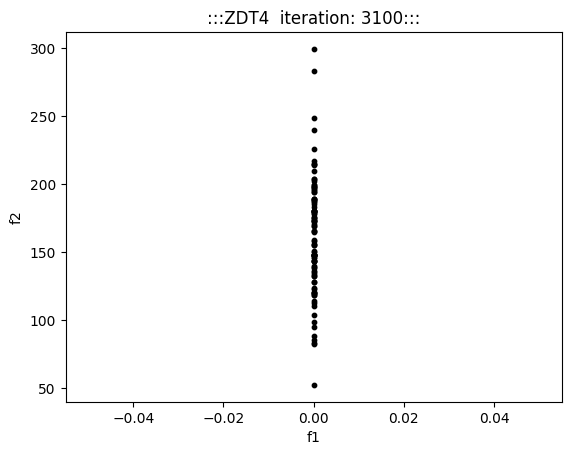

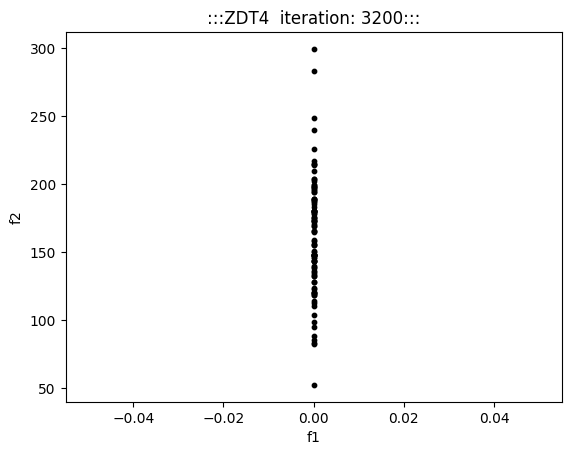

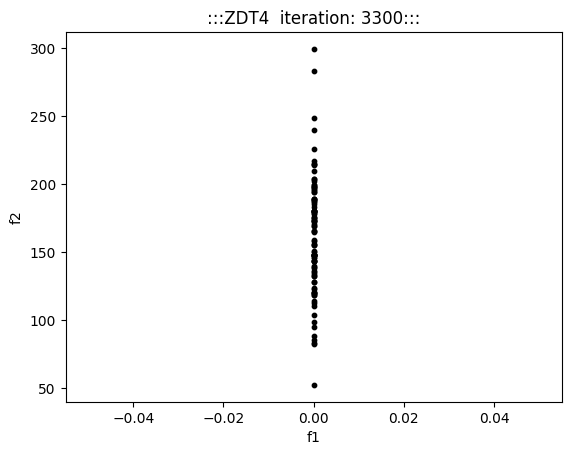

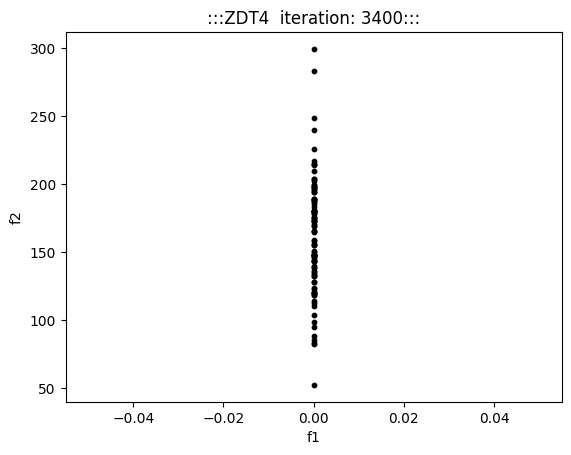

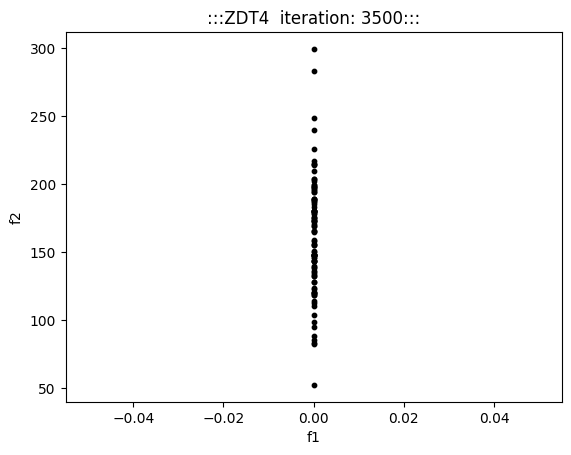

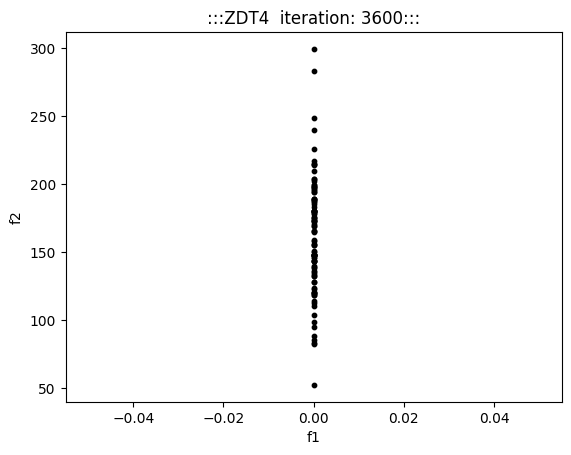

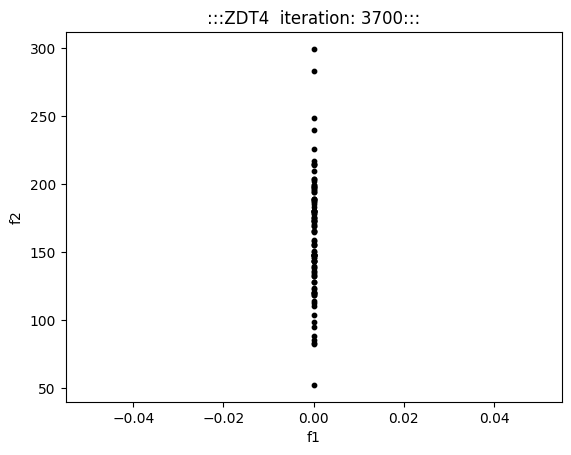

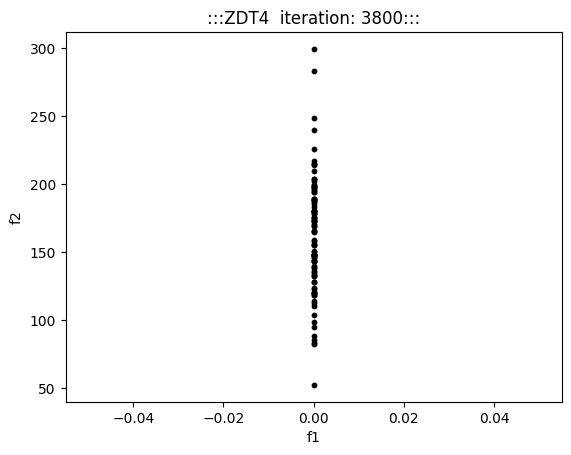

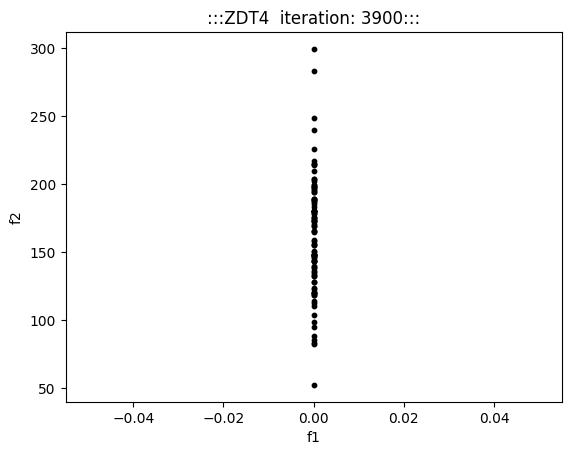

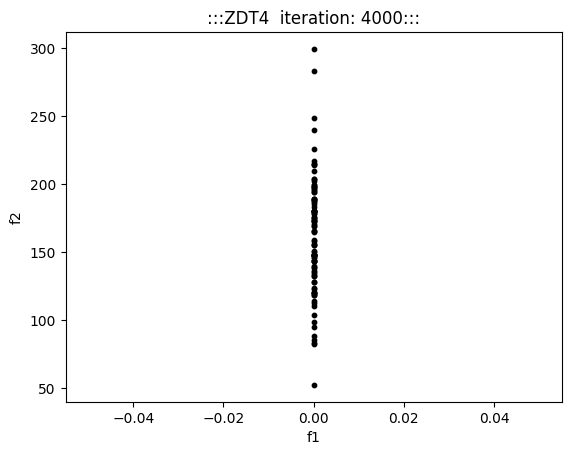

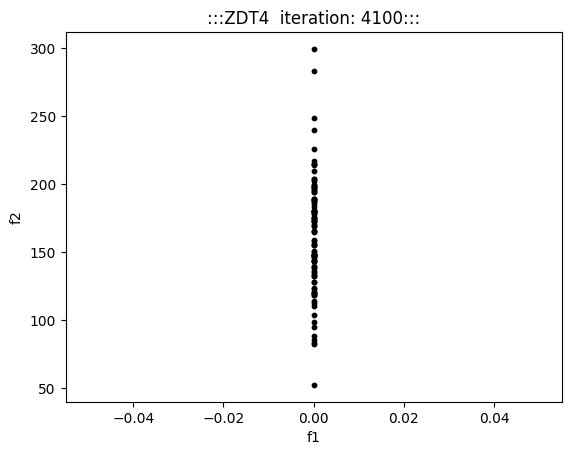

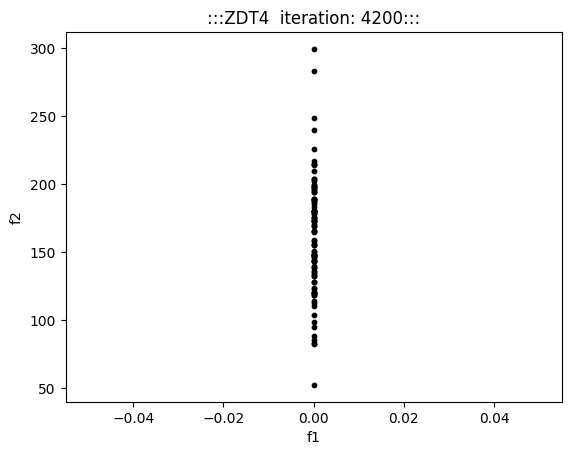

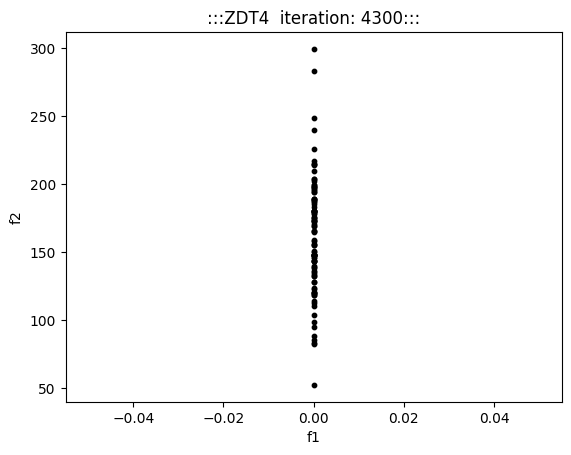

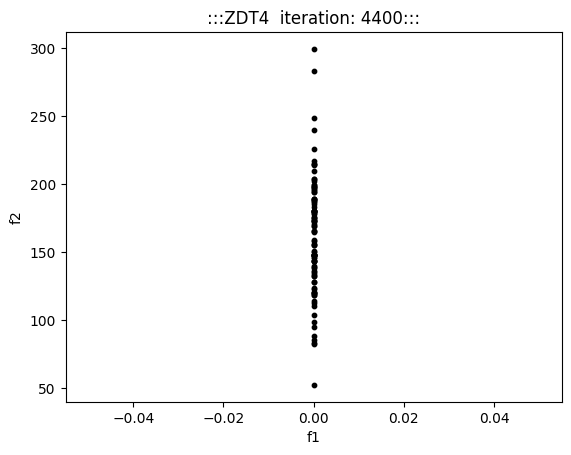

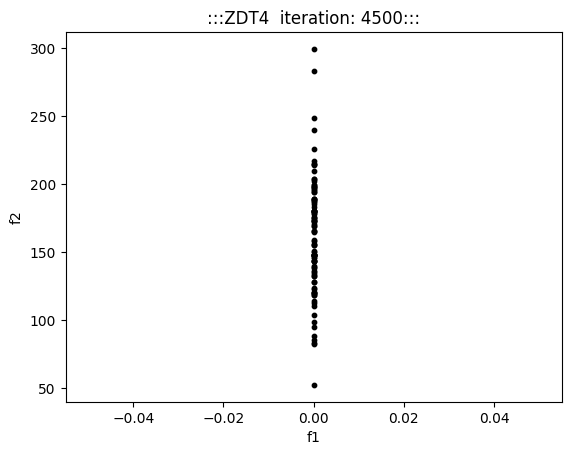

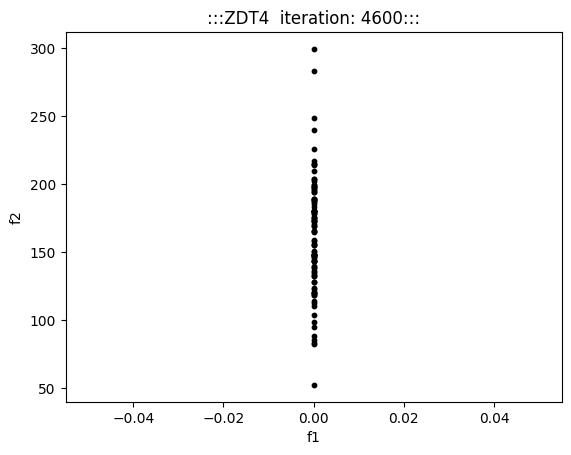

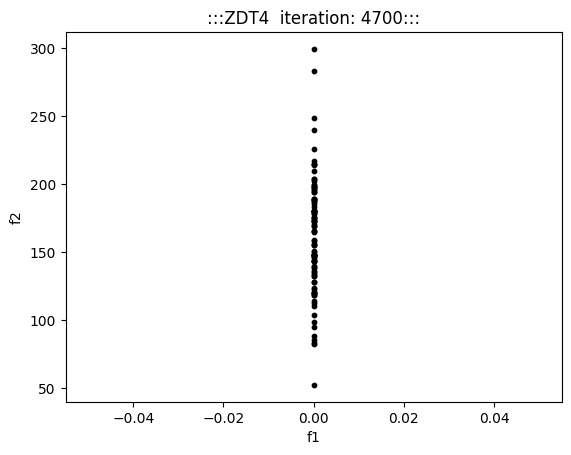

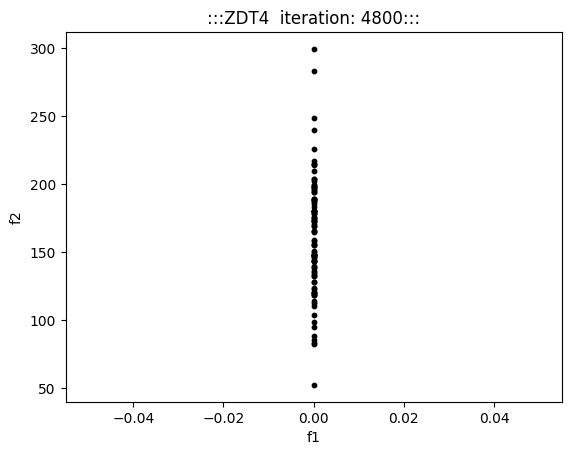

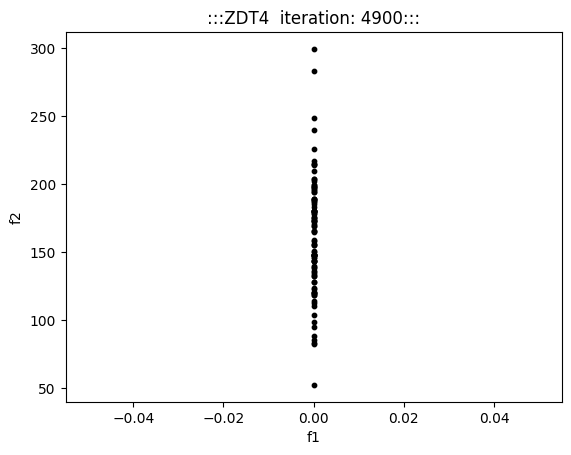

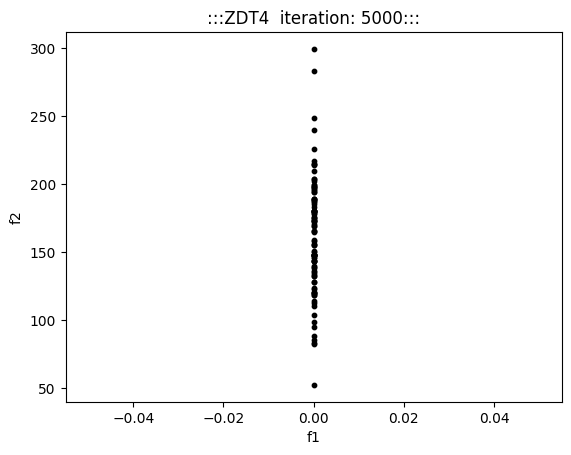

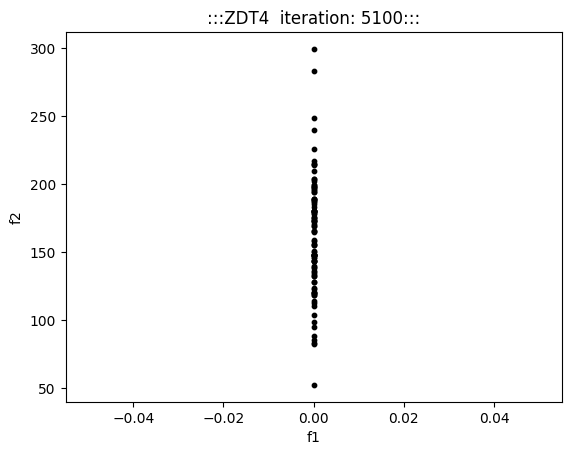

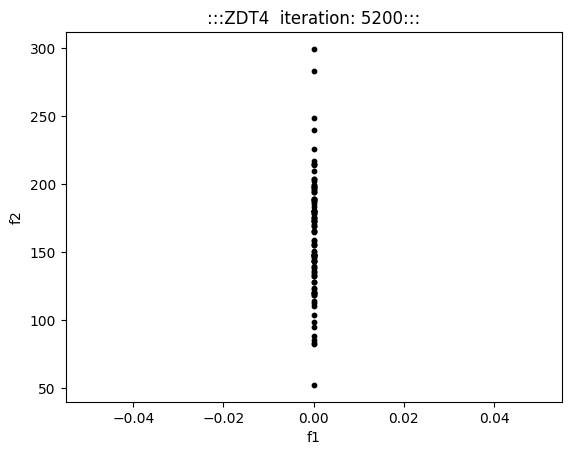

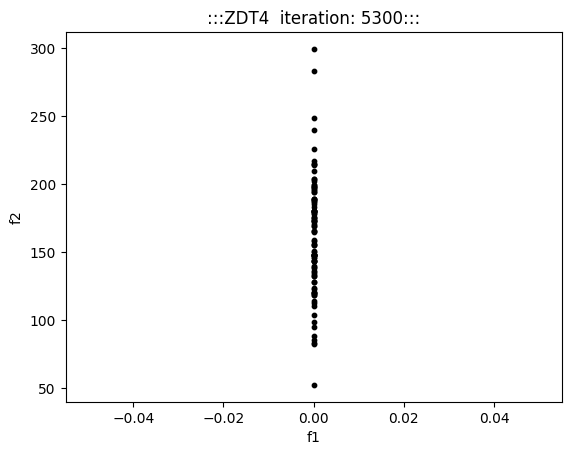

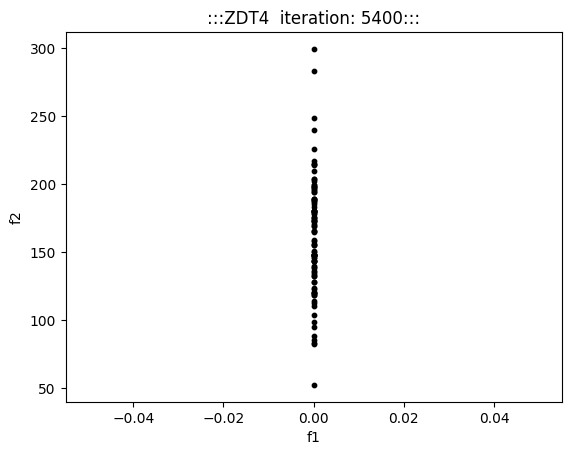

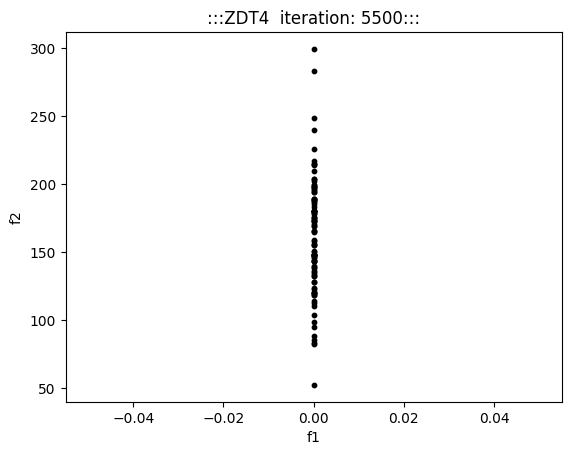

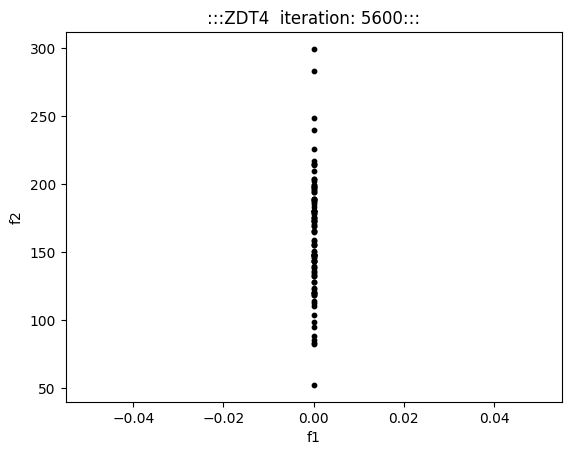

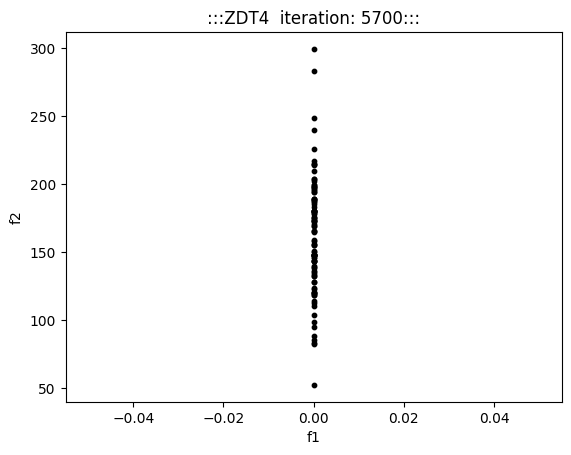

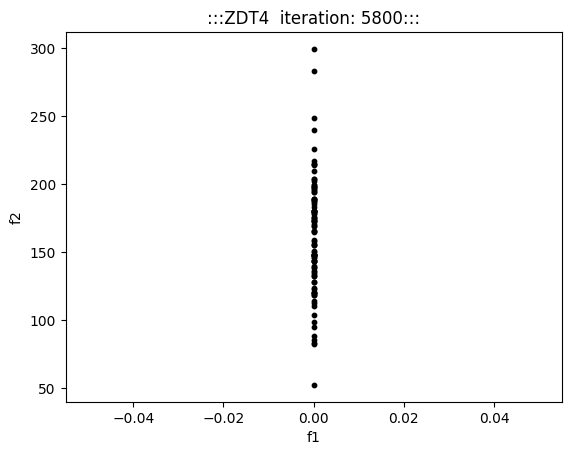

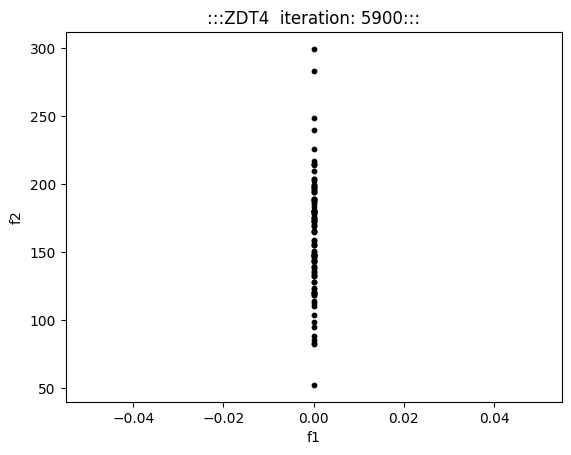

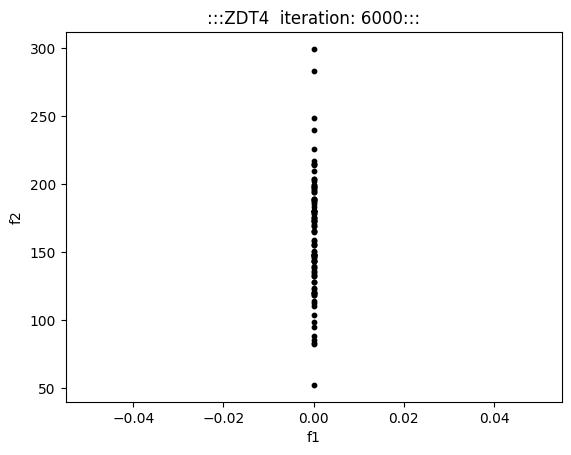

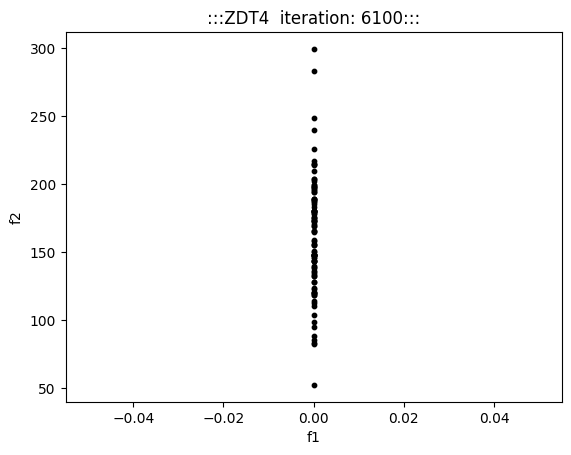

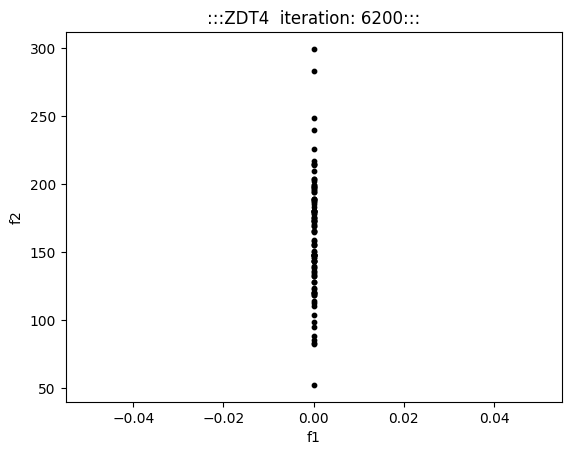

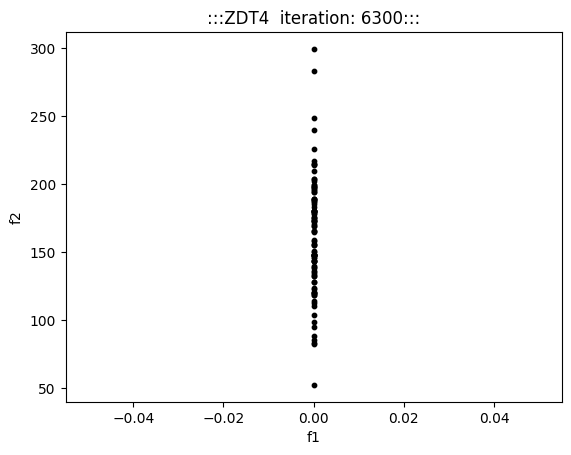

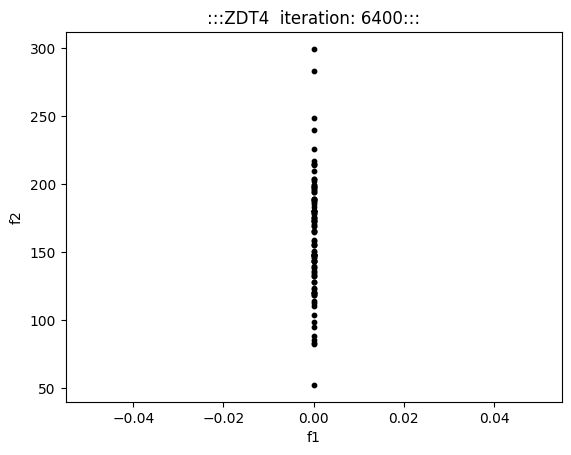

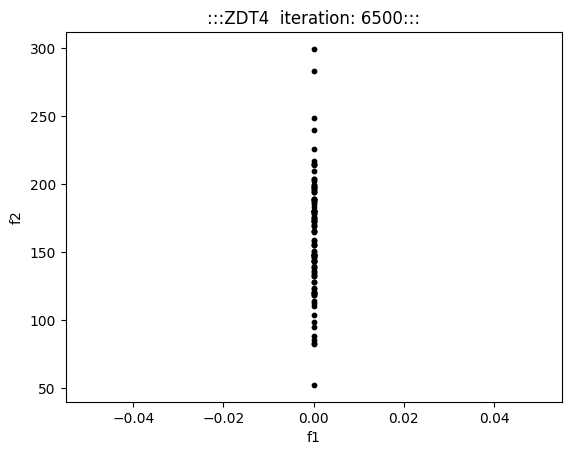

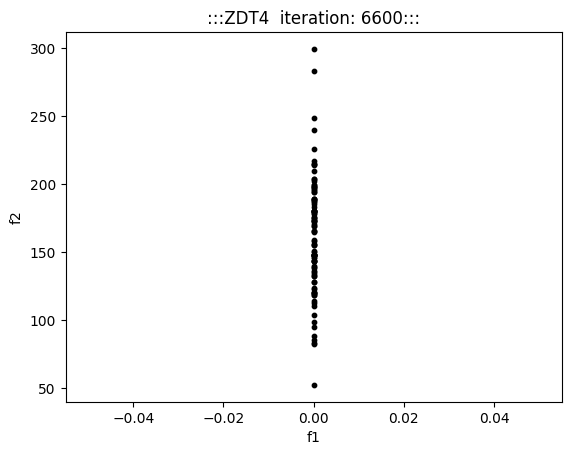

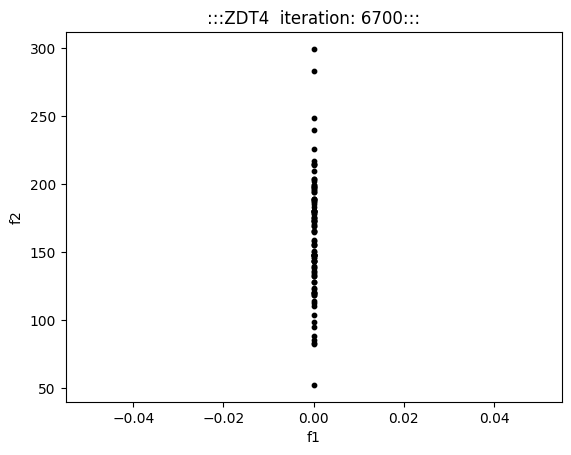

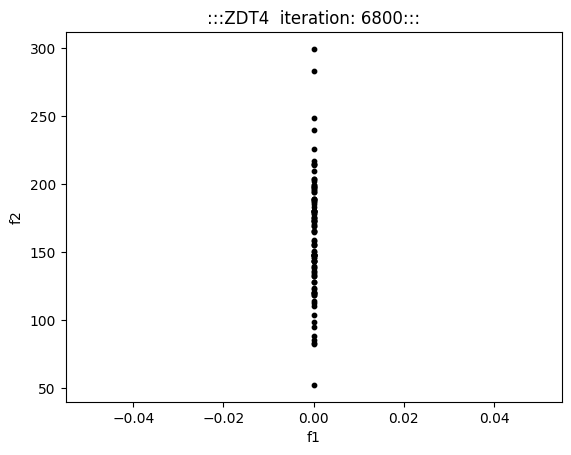

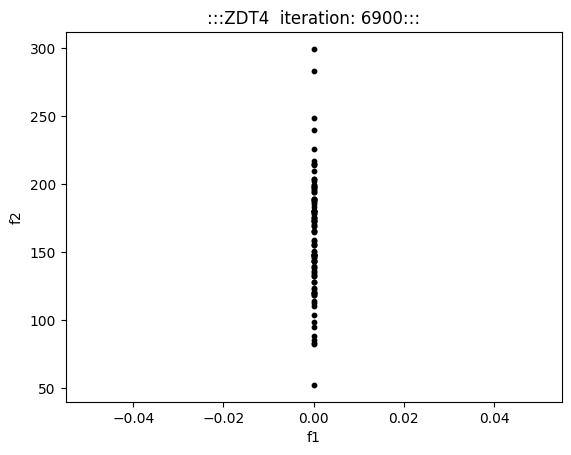

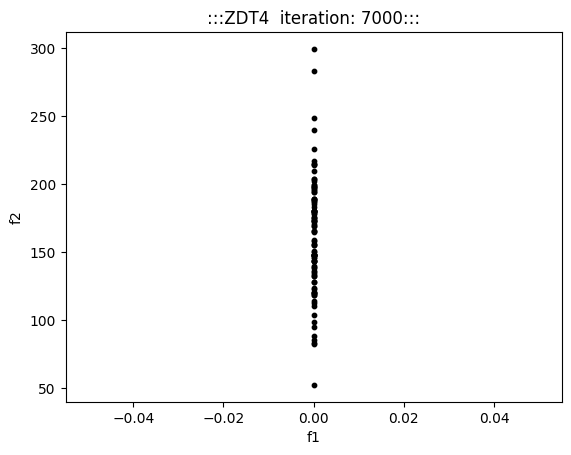

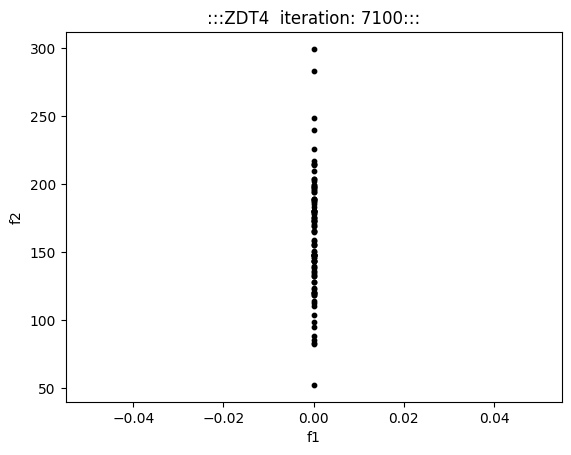

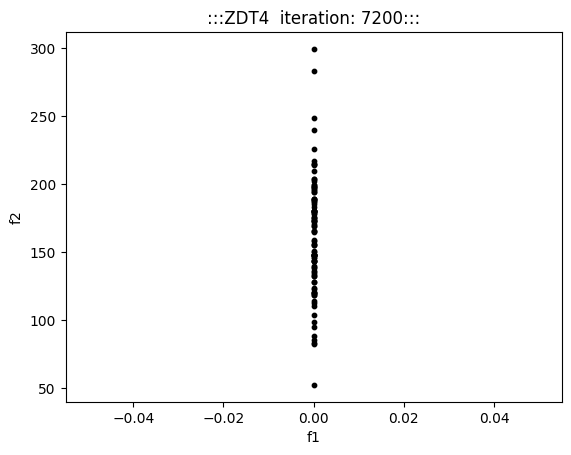

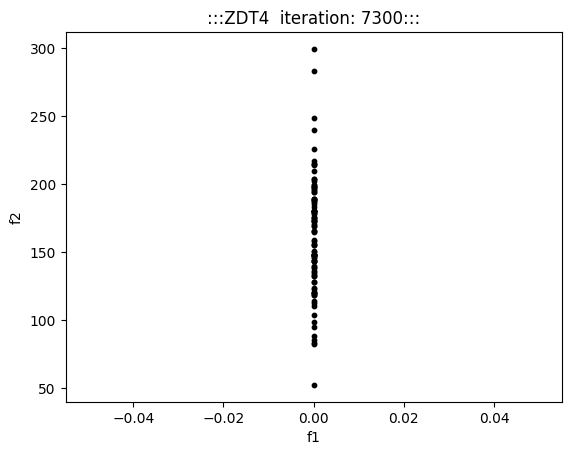

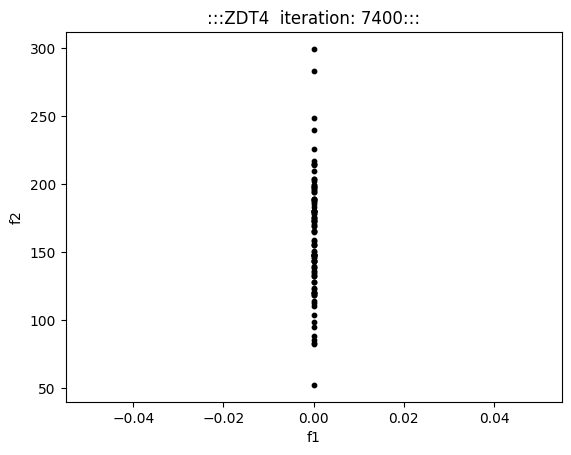

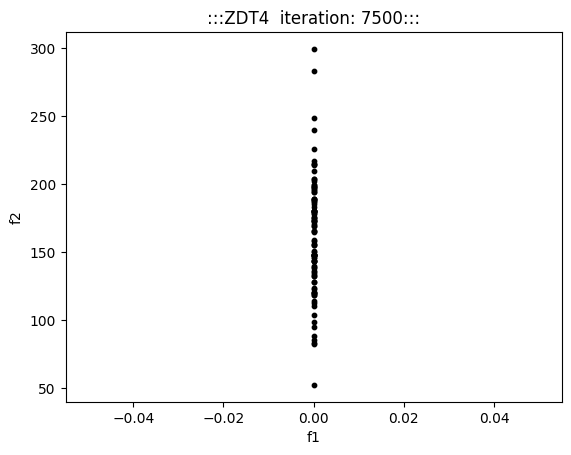

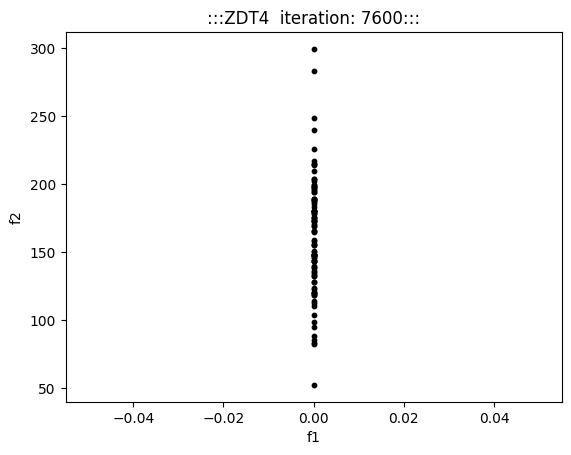

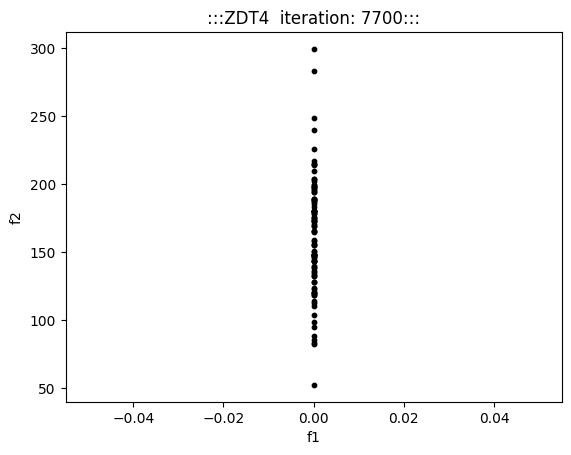

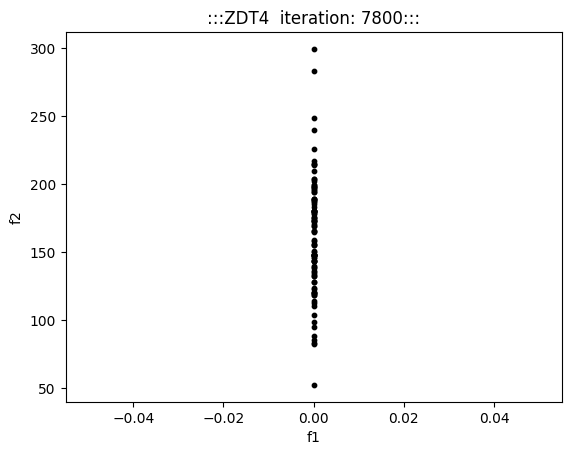

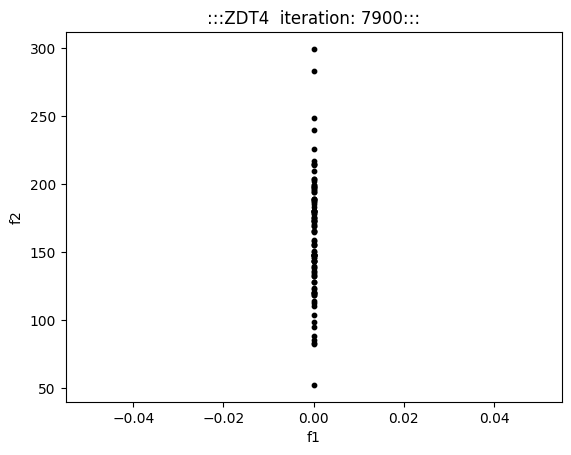

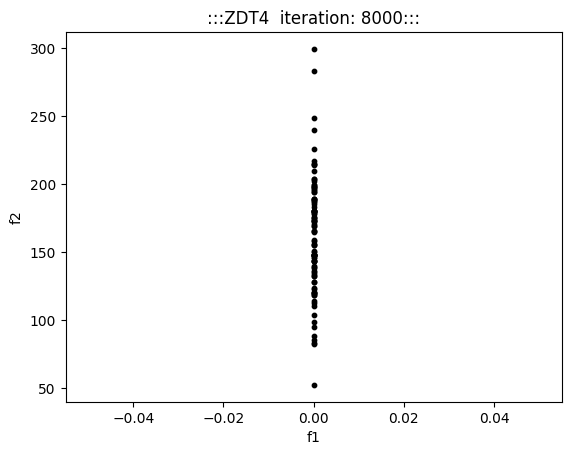

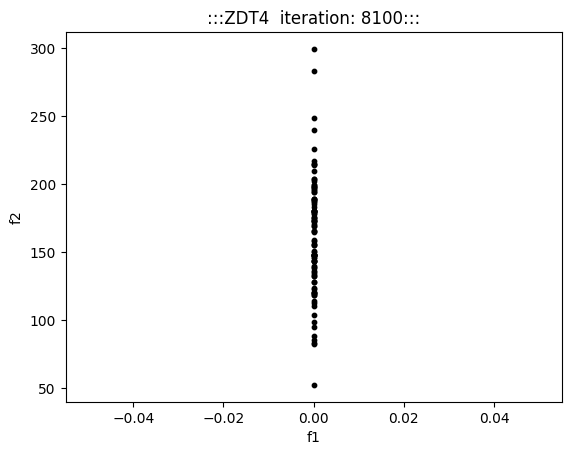

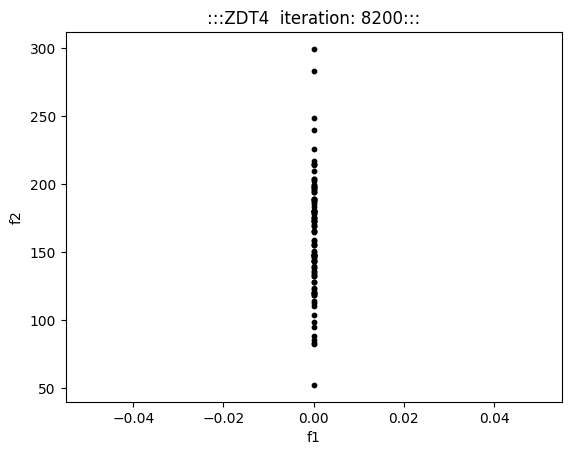

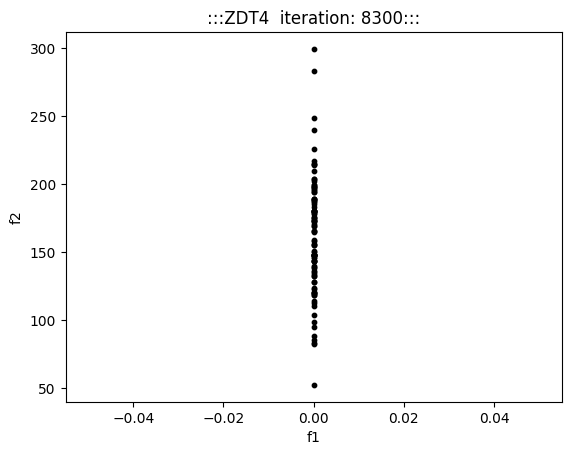

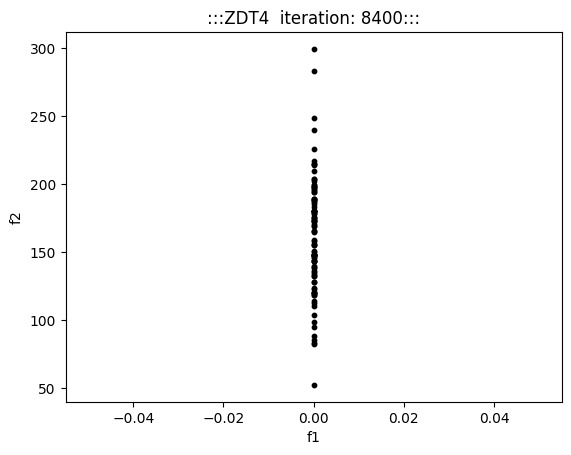

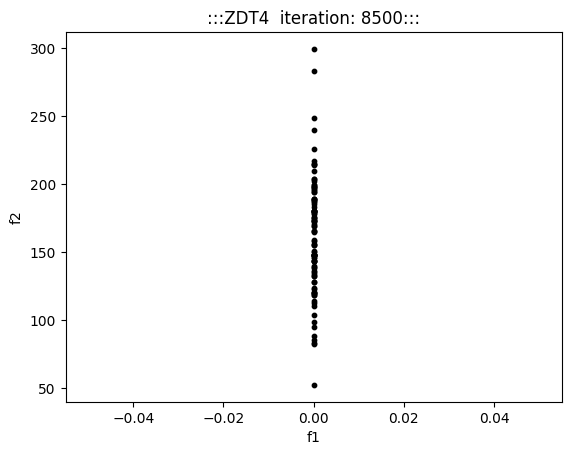

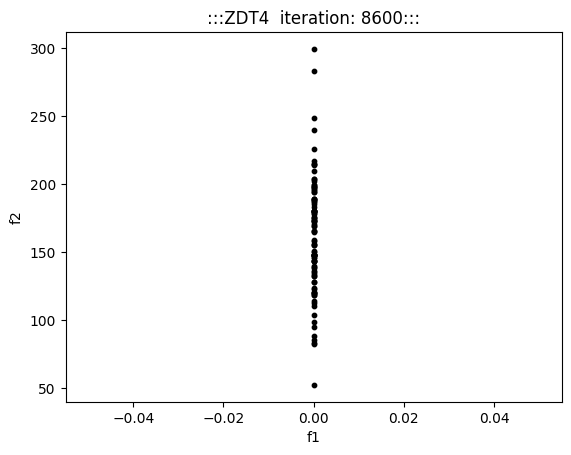

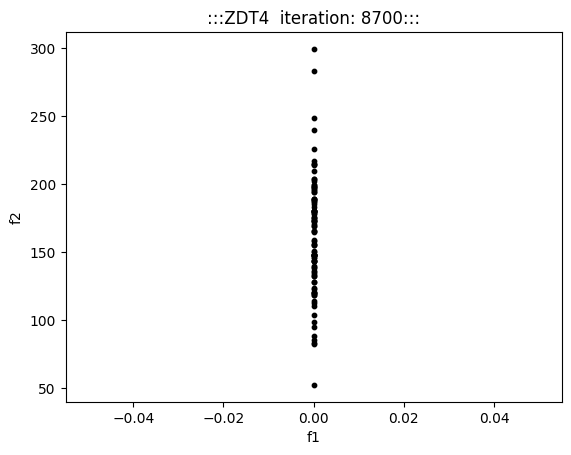

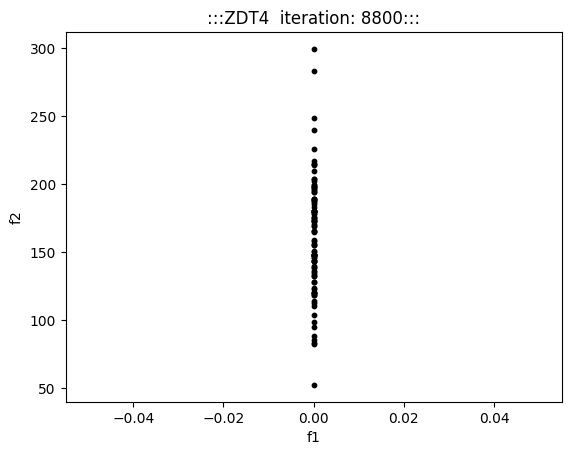

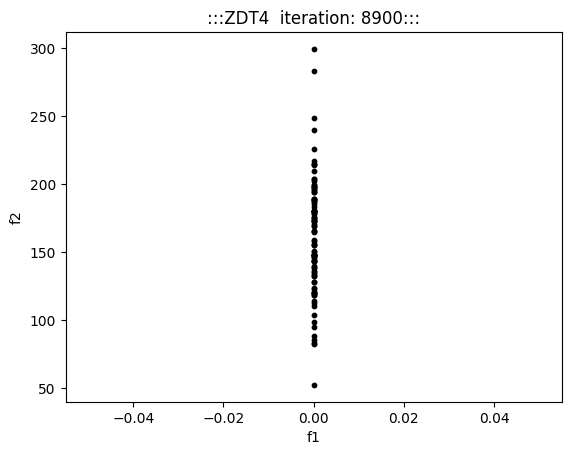

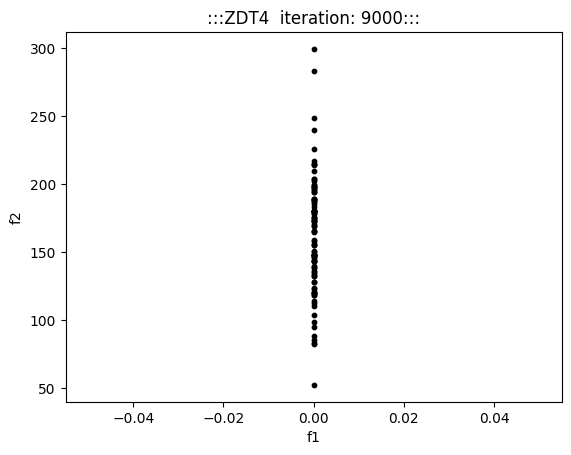

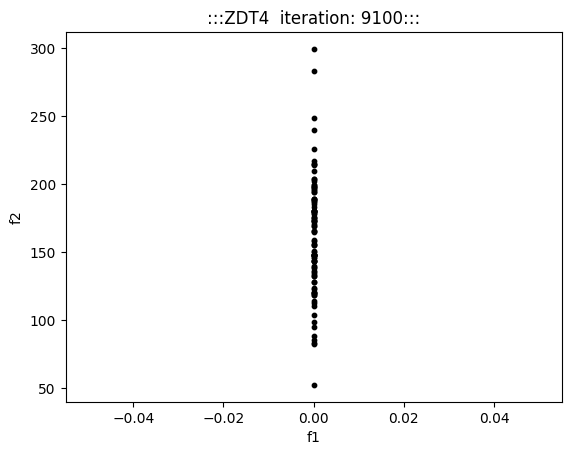

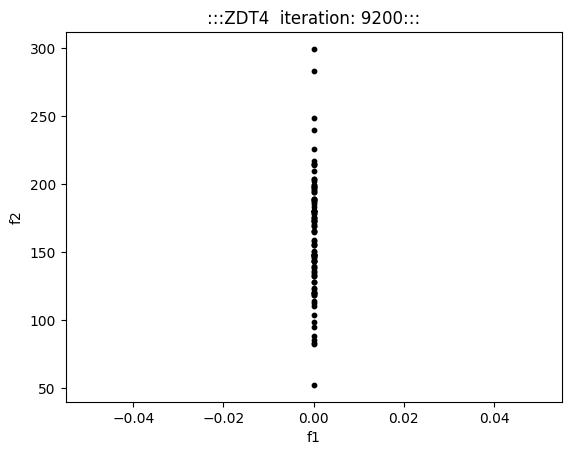

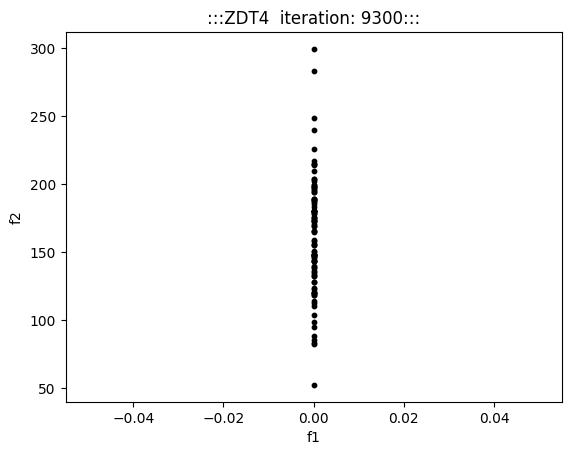

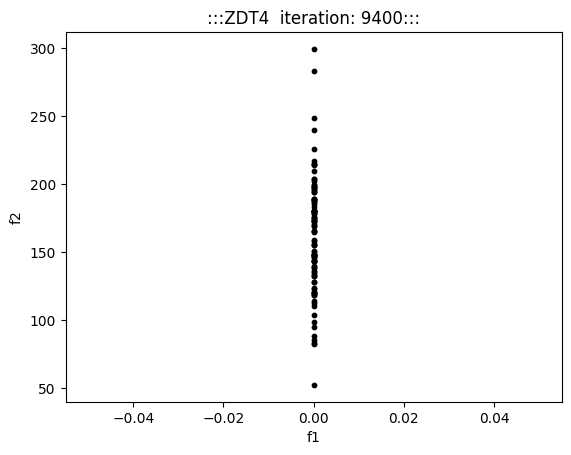

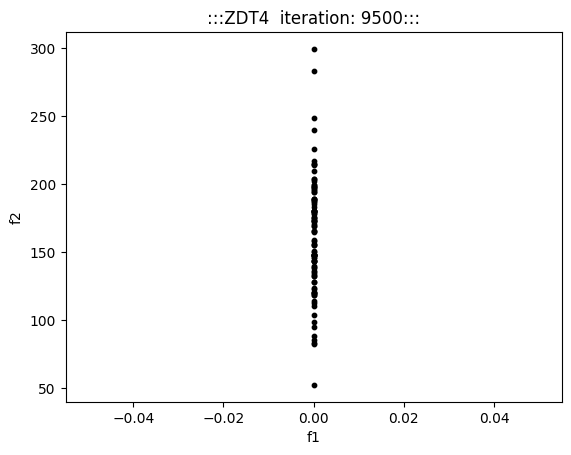

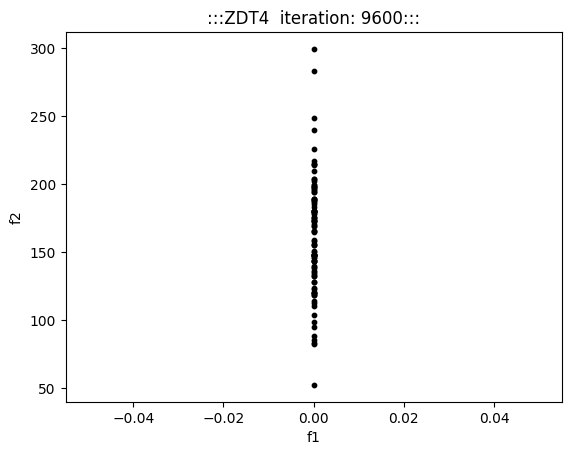

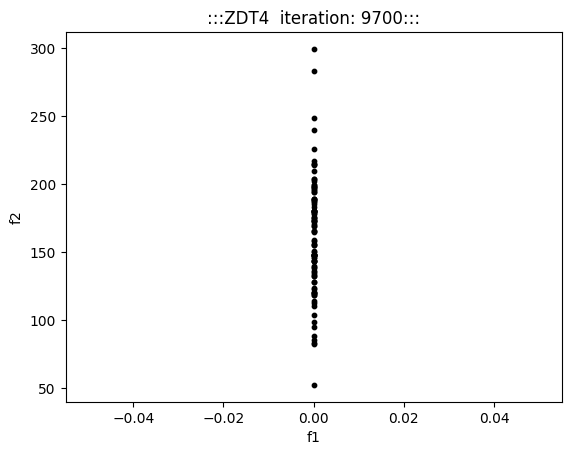

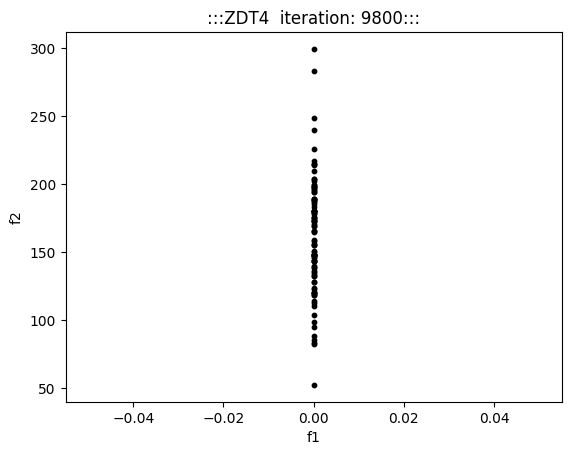

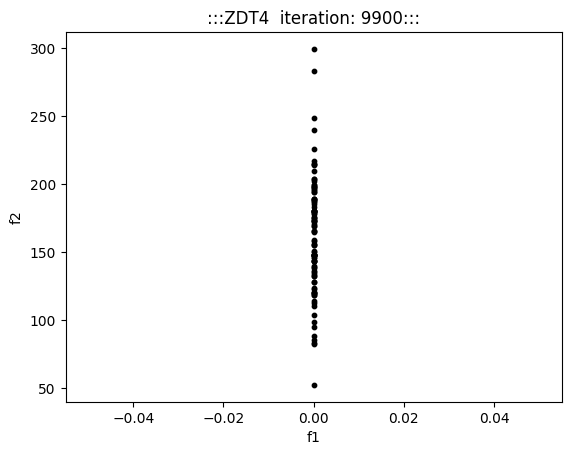

In [1858]:
"""
#> I. 초기해 생성
"""
iteration = 0
solution = generate_initial_solution()
plot_for_solution(solution, iteration)

# print(solution)
# print(len(solution))


while iteration < 10000:
    """
    #> II. Rank기반 Roulette-wheel 적용해서 num_pop만큼 offsprings 만들기
    """
    off_solution = select_based_on_rank(solution)

    """
    #> III. Operator
    """
    #> model 1
    mixed_solution = copy.deepcopy(solution)
    for idx in range(0,len(off_solution)):
        mixed_solution.append(off_solution[idx])

    
    new_solution = model1_op(mixed_solution)
    # print(len(solution))

    # for idx in range(0,len(new_solution)):
    #     print(solution[idx])

    # print('new_solution: {new_solution}')
    
    if iteration % 100 == 0:
        plot_for_solution(new_solution, iteration)
    solution = copy.deepcopy(new_solution)
    
    # for i in range(0, len(solution)):
    #     print(ZDT4(chromosome_bin_to_decimal(solution[i])))
    
    iteration = iteration + 1



### Results

In [1764]:
rank_operator(solution)

[3,
 6,
 6,
 1,
 3,
 12,
 9,
 4,
 4,
 13,
 6,
 13,
 12,
 9,
 6,
 8,
 2,
 11,
 6,
 2,
 2,
 11,
 10,
 7,
 1,
 15,
 11,
 12,
 12,
 11,
 5,
 4,
 7,
 4,
 2,
 6,
 6,
 1,
 2,
 7,
 8,
 11,
 9,
 8,
 2,
 8,
 12,
 7,
 14,
 5,
 1,
 7,
 6,
 4,
 10,
 1,
 4,
 5,
 11,
 11,
 1,
 5,
 3,
 10,
 7,
 5,
 2,
 10,
 12,
 9,
 3,
 14,
 1,
 10,
 1,
 1,
 6,
 5,
 10,
 11,
 1,
 7,
 9,
 7,
 3,
 7,
 5,
 12,
 10,
 8,
 1,
 11,
 3,
 10,
 6,
 5,
 3,
 2,
 5,
 6]

-- DEBUG

In [1618]:
for i in range(0, len(solution)):
    print(ZDT4(chromosome_bin_to_decimal(solution[i])))

print("\n")

off_solution = select_based_on_rank(solution)
for i in range(0, len(off_solution)):
    print(ZDT4(chromosome_bin_to_decimal(off_solution[i])))

[0.0, 190.25]
[0.25, 46.76593476022222]
[0.25, 48.69613096462764]
[0.25, 84.64808239970274]
[0.0, 139.125]
[0.25, 67.87867806213424]
[0.0, 163.4375]
[0.0, 121.25]
[0.0, 207.3125]
[0.25, 73.21974745332348]


[0.0, 131.125]
[0.25, 121.60974291366077]
[0.0, 143.375]
[0.0, 159.1875]
[0.0, 132.25]
[0.0, 179.25]
[0.25, 183.35344288793314]
[0.0, 50.3125]
[0.25, 136.59252303187023]
[0.0, 112.3125]
